<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/skripsi_cnn_lstm_windowed_data_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Prediksi Harga Bahan Pangan di Indonesia
import semua library yang dibutuhkan pada awal project, berfungsi untuk mempermudah dalam organisir kode, library yang akan digunakan adalah:

*   `urllib` untuk mengambil data dari url dan menyimpan kembali menjadi format data tertentu
*   `numpy`
*   `pandas` digunakan untuk membaca data dari file ekstention csv dan untuk memnganalisis data
*   `seaborn`
*   `tensorflow` digunakan dalam proses pembuatan model deep learning
*   `matplotlib`merupakan library untuk menamilkan plot dari data 
*   `sklearn` merupakan library untuk modeling data supervised learning dan unsupervised learning, dalam project ini digunakan untuk split data

In [6]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## data **generator**

In [7]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_time_step = generate_data.window(time_size+1, shift=1, drop_remainder=True)
  flatten_window = add_window_time_step.flat_map(lambda window : window.batch(time_size+1))
  tuple_feature_label = flatten_window.map(lambda window: (window[:-1], window[-1]))
  shuffle_data = tuple_feature_label.shuffle(shuffle_data)
  batch_window = shuffle_data.batch(batch_size).prefetch(1)
  
  return batch_window

In [8]:
def forecast_predict(model, data, time_size, batch_size, shuffle_data):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

functions *plot value* digunakan untuk menampilkan grafik hasil training model terhadap data, value yang ingin ditampilkan yaitu nilai loss, mape dan mae (disuaikan dengan *metrics *yang digunakan)

In [9]:
def plot_value(history, name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  mae = history.history['mae']
  epoch = range(len(loss))

  plt.title(name)
  plt.plot(epoch, loss, 'r', label='loss')
  plt.plot(epoch, val_loss, 'y', label='val_loss')
  plt.legend()
  plt.show()

Function model_evaluate digunakan untuk melihat nilai evaluasi dari model yang telah dibuat berdasarkan data prediksi, model akan dievaluasi berdasarkan nilai mae, mape, dan rmse

In [10]:
def model_evaluate(data_actual, value_prediction):
  mae = mean_absolute_error(data_actual, value_prediction).numpy()
  mape = mean_absolute_percentage_error(data_actual, value_prediction).numpy()
  mse = mean_squared_error(data_actual, value_prediction).numpy()
  rmse = RootMeanSquaredError(data_actual, value_prediction).numpy()

  print(f"Nilai mae yang didapatkan untuk memprediksi {len(data_actual)} adalah = {mae}\nNilai mape yang diperoleh adalah = {mape}")

## Load Data
Data diambil dari 

In [11]:
data_url = 'https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_harga_bahan_pangan_indonesia.csv?raw=true'
urllib.request.urlretrieve(data_url, 'data_pangan_indonesia.csv')

('data_pangan_indonesia.csv', <http.client.HTTPMessage at 0x7ff95b8bf5d0>)

Read data csv dengan pandas 

In [12]:
data_pangan = pd.read_csv('data_pangan_indonesia.csv')
data_pangan

,Date,Beras,Beras Kualitas Bawah I (kg),Beras Kualitas Bawah II (kg),Beras Kualitas Medium I (kg),Beras Kualitas Medium II (kg),Beras Kualitas Super I (kg),Beras Kualitas Super II (kg),Daging Ayam,Daging Ayam Ras Segar (kg),...,Cabai Rawit,Cabai Rawit Hijau (kg),Cabai Rawit Merah (kg),Minyak Goreng,Minyak Goreng Curah (kg),Minyak Goreng Kemasan Bermerk 1 (kg),Minyak Goreng Kemasan Bermerk 2 (kg),Gula Pasir,Gula Pasir Kualitas Premium (kg),Gula Pasir Lokal (kg)
0,01/08/2017,11200,10150,9650,11250,11150,12750,12250,34100,34100,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,02/08/2017,11200,10150,9650,11250,11150,12750,12250,34150,34150,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
2,03/08/2017,11200,10150,9650,11250,11150,12700,12250,34250,34250,...,40350,34650,46050,13950,12250,15050,14350,14900,16800,13250
3,04/08/2017,11300,10150,10300,11250,11150,12750,12250,34300,34300,...,40500,34600,46550,13950,12200,15050,14350,14900,16800,13250
4,07/08/2017,11200,10150,9650,11250,11150,12750,12250,34350,34350,...,39500,34300,44900,13950,12200,15050,14350,14900,16800,13250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,25/04/2022,11750,10700,10450,11800,11600,13100,12650,38750,38750,...,45500,42750,46900,24600,19700,26950,25950,15350,16000,14800
1170,26/04/2022,11750,10700,10450,11800,11550,13100,12650,39100,39100,...,45500,42550,47100,24600,19600,26950,25900,15350,16000,14850
1171,27/04/2022,11850,10700,10450,11800,11550,13100,13000,39600,39600,...,45750,42800,47750,24650,19700,27050,26000,15350,16000,14850
1172,28/04/2022,11850,10700,10400,11800,11600,13100,13000,40350,40350,...,46050,42500,48250,24600,19650,27050,26000,15350,16000,14850


*italicized text*## Data Understanding
Data yang akan digunakan berjumlah 1174 dengan 32 kolom dengan keterangan:
1. Date : merupakan tanggal proses pengambilan data/sampel data
2. Beras: harga beras secara kumulatif
2. Beras Kualitas Bawah I : data harga beras dengan kualitas bawah 1/pengambilan data berdasarkan harga per-kilogram
3. Beras Kualitas Bawah II : data harga beras dengan kualitas bawah 2/pengambilan data berdasarkan harga per-kilogram
4. Beras Kualitas Medium I (kg) : 
5. Beras Kualitas Medium II 
1. Beras Kualitas Super II (kg)
2. Daging Ayam
3. Daging Ayam Ras Segar
4. Daging Sapi
5. Daging Sapi Kualitas 1
6. Daging Sapi Kualitas 2,
7. Telur Ayam
8. Telur Ayam Ras Segar
9. Bawang Merah
10. Bawang Merah Ukuran Sedang
11. Bawang Putih,
12. Bawang Putih Ukuran Sedang (kg)
13. Cabai Merah
14. Cabai Merah Besar
15. Cabai Merah Keriting
16. Cabai Rawit
17. Cabai Rawit Hijau
18. Cabai Rawit Merah
19. Minyak Goreng
20. Minyak Goreng Curah
21. Minyak Goreng Kemasan Bermerk 1
22. Minyak Goreng Kemasan Bermerk 2
23. Gula Pasir
24. Gula Pasir Kualitas Premium
26. Gula Pasir Lokal



In [13]:
data_pangan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Date                                  1174 non-null   object
 1   Beras                                 1174 non-null   int64 
 2   Beras Kualitas Bawah I (kg)           1174 non-null   int64 
 3   Beras Kualitas Bawah II (kg)          1174 non-null   int64 
 4   Beras Kualitas Medium I (kg)          1174 non-null   int64 
 5   Beras Kualitas Medium II (kg)         1174 non-null   int64 
 6   Beras Kualitas Super I (kg)           1174 non-null   int64 
 7   Beras Kualitas Super II (kg)          1174 non-null   int64 
 8   Daging Ayam                           1174 non-null   int64 
 9   Daging Ayam Ras Segar (kg)            1174 non-null   int64 
 10  Daging Sapi                           1174 non-null   int64 
 11  Daging Sapi Kualitas 1 (kg)   

In [14]:
print(f'jumlah data {len(data_pangan)}')
print(f'ukuran dari data {data_pangan.shape}')
data_pangan.columns

jumlah data 1174
ukuran dari data (1174, 32)


Index(['Date', 'Beras', 'Beras Kualitas Bawah I (kg)',
       'Beras Kualitas Bawah II (kg)', 'Beras Kualitas Medium I (kg)',
       'Beras Kualitas Medium II (kg)', 'Beras Kualitas Super I (kg)',
       'Beras Kualitas Super II (kg)', 'Daging Ayam',
       'Daging Ayam Ras Segar (kg)', 'Daging Sapi',
       'Daging Sapi Kualitas 1 (kg)', 'Daging Sapi Kualitas 2 (kg)',
       'Telur Ayam', 'Telur Ayam Ras Segar(kg)', 'Bawang Merah',
       'Bawang Merah Ukuran Sedang (kg)', 'Bawang Putih',
       'Bawang Putih Ukuran Sedang (kg)', 'Cabai Merah',
       'Cabai Merah Besar (kg)', 'Cabai Merah Keriting  (kg)', 'Cabai Rawit',
       'Cabai Rawit Hijau (kg)', 'Cabai Rawit Merah (kg)', 'Minyak Goreng',
       'Minyak Goreng Curah (kg)', 'Minyak Goreng Kemasan Bermerk 1 (kg)',
       'Minyak Goreng Kemasan Bermerk 2 (kg)', 'Gula Pasir',
       'Gula Pasir Kualitas Premium (kg)', 'Gula Pasir Lokal (kg)'],
      dtype='object')

### EDA

In [15]:
dataset = data_pangan
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.columns = dataset.columns.str.replace(' (kg)', '', regex=False).str.replace('(kg)', '', regex=False).str.replace(' ', '_').str.lower()
dataset['date'] = pd.to_datetime(dataset.date)
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam,daging_ayam_ras_segar,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,34100,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,34150,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
2,2017-03-08,11200,10150,9650,11250,11150,12700,12250,34250,34250,...,40350,34650,46050,13950,12250,15050,14350,14900,16800,13250
3,2017-04-08,11300,10150,10300,11250,11150,12750,12250,34300,34300,...,40500,34600,46550,13950,12200,15050,14350,14900,16800,13250
4,2017-07-08,11200,10150,9650,11250,11150,12750,12250,34350,34350,...,39500,34300,44900,13950,12200,15050,14350,14900,16800,13250


In [16]:
dataset.isna().sum()

date                               0
beras                              0
beras_kualitas_bawah_i             0
beras_kualitas_bawah_ii            0
beras_kualitas_medium_i            0
beras_kualitas_medium_ii           0
beras_kualitas_super_i             0
beras_kualitas_super_ii            0
daging_ayam                        0
daging_ayam_ras_segar              0
daging_sapi                        0
daging_sapi_kualitas_1             0
daging_sapi_kualitas_2             0
telur_ayam                         0
telur_ayam_ras_segar               0
bawang_merah                       0
bawang_merah_ukuran_sedang         0
bawang_putih                       0
bawang_putih_ukuran_sedang         0
cabai_merah                        0
cabai_merah_besar                  0
cabai_merah_keriting_              0
cabai_rawit                        0
cabai_rawit_hijau                  0
cabai_rawit_merah                  0
minyak_goreng                      0
minyak_goreng_curah                0
m

In [17]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
max_beras = dataset.beras.max()
min_beras = dataset.beras.min()
id_max_beras = dataset.beras.idxmax()
print(f'nilai maksimum harga beras {max_beras} pada tanggal {id_max_beras} \nharga minimun beras {min_beras}')

nilai maksimum harga beras 13100 pada tanggal 2019-06-06 00:00:00 
harga minimun beras 10700


In [18]:
dataset

,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam,daging_ayam_ras_segar,daging_sapi,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
date,,,,,,,,,,,,,,,,,,,,,
2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,34100,115150,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,30350,113850,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,29350,112600,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,34150,115150,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,30200,115000,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02,11800,10750,10500,11800,11600,13100,12650,35650,35650,125050,...,49750,44950,53000,18750,17500,19750,18400,14800,15550,14250
2022-11-03,11800,10750,10450,11800,11600,13100,12650,36250,36250,127350,...,60250,47900,72400,19350,17050,20600,19550,14750,15450,14200
2022-11-04,11800,10700,10450,11800,11600,13100,12650,37500,37500,130250,...,52400,46350,57200,24300,19900,26400,25550,15250,15850,14750


Text(0, 0.5, 'harga')

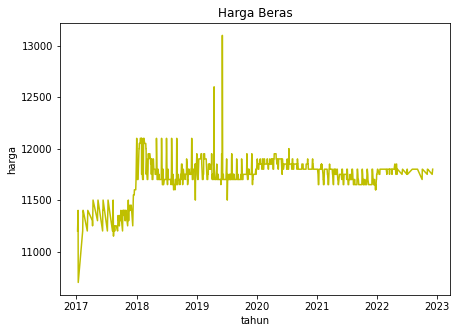

In [19]:
plt.figure(figsize=(7, 5))
plt.plot(dataset.index, dataset.beras, 'y')
plt.title('Harga Beras')
plt.xlabel('tahun')
plt.ylabel('harga')

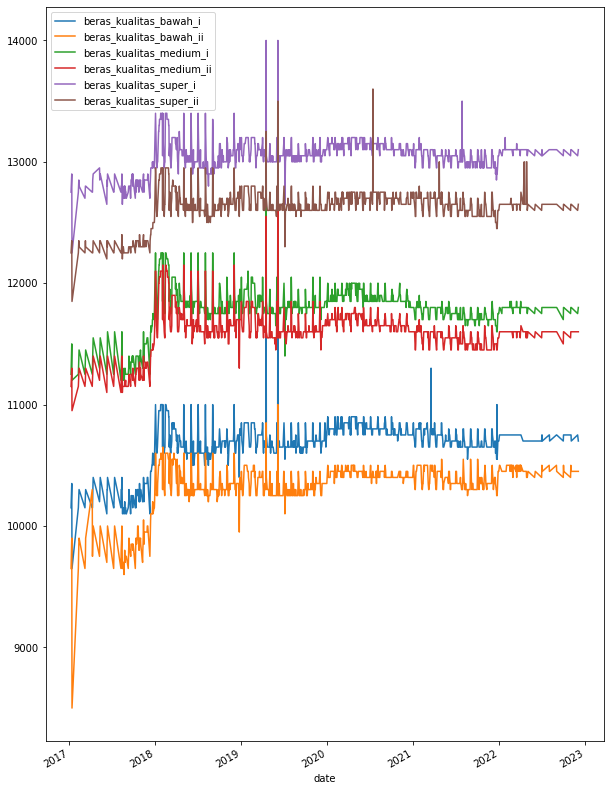

In [20]:
dataset.iloc[:, 1:7].plot(figsize=(10, 15))

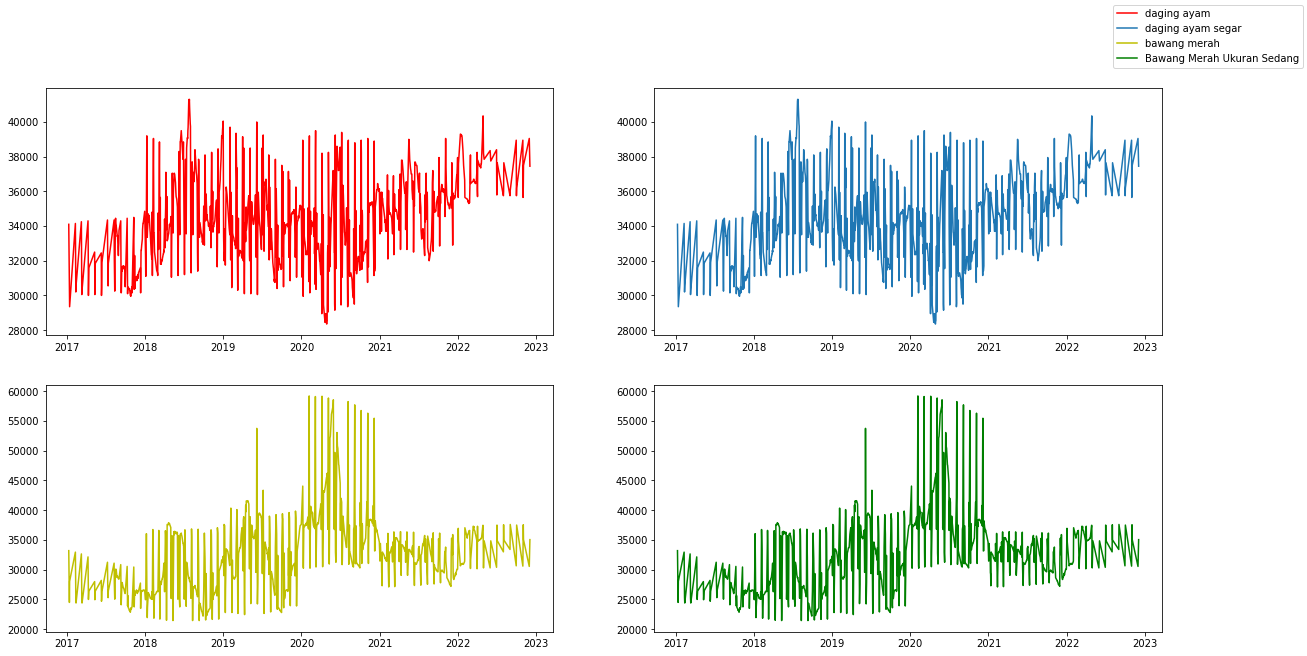

In [21]:
fig, ax = plt.subplots(2,2, figsize=(20, 10))
ax[0,0].plot(dataset.index, dataset['daging_ayam'],'r', label='daging ayam')
ax[0,1].plot(dataset.index, dataset['daging_ayam_ras_segar'], label='daging ayam segar')
ax[1,0].plot(dataset.index, dataset['bawang_merah'],'y', label='bawang merah')
ax[1,1].plot(dataset.index, dataset['bawang_merah_ukuran_sedang'], 'g', label='Bawang Merah Ukuran Sedang')
fig.legend()

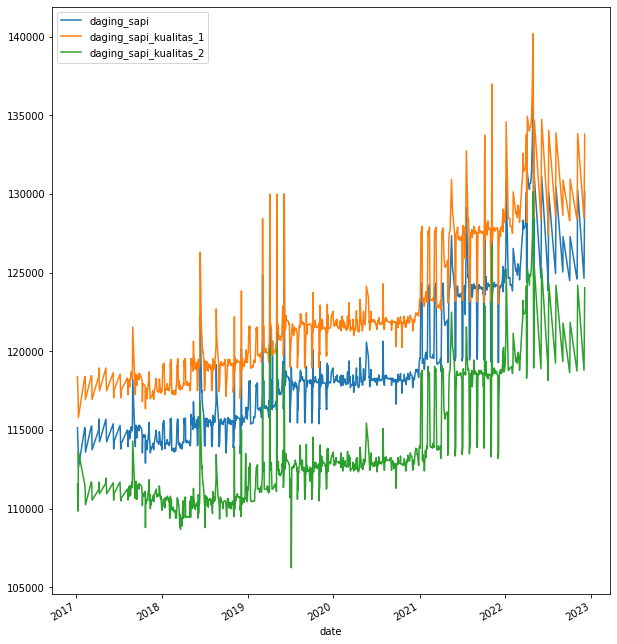

In [22]:
dataset.iloc[:, 9:12].plot(figsize=(10, 12))

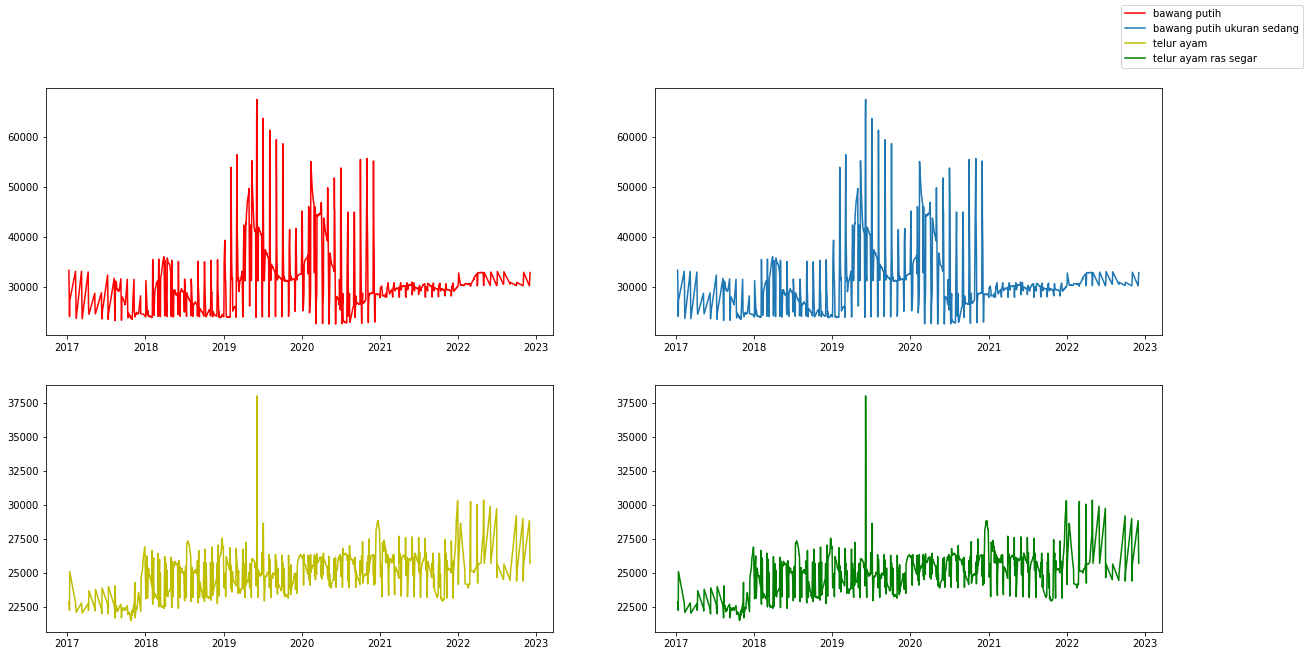

In [23]:
fig, ax = plt.subplots(2,2, figsize=(20, 10))
ax[0,0].plot(dataset.index, dataset['bawang_putih'],'r', label='bawang putih')
ax[0,1].plot(dataset.index, dataset['bawang_putih_ukuran_sedang'], label='bawang putih ukuran sedang')
ax[1,0].plot(dataset.index, dataset['telur_ayam'],'y', label='telur ayam')
ax[1,1].plot(dataset.index, dataset['telur_ayam_ras_segar'], 'g', label='telur ayam ras segar')
fig.legend()

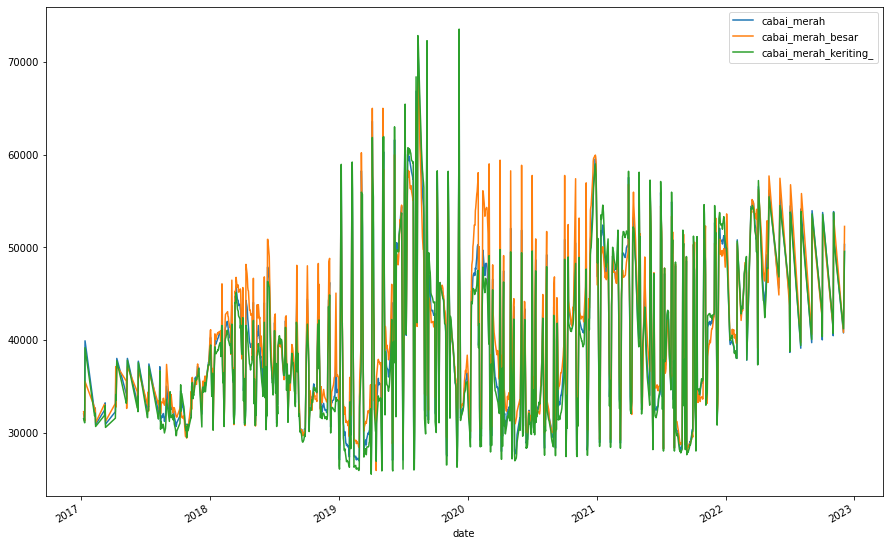

In [24]:
dataset.iloc[:, 18:21].plot(figsize=(15, 10))

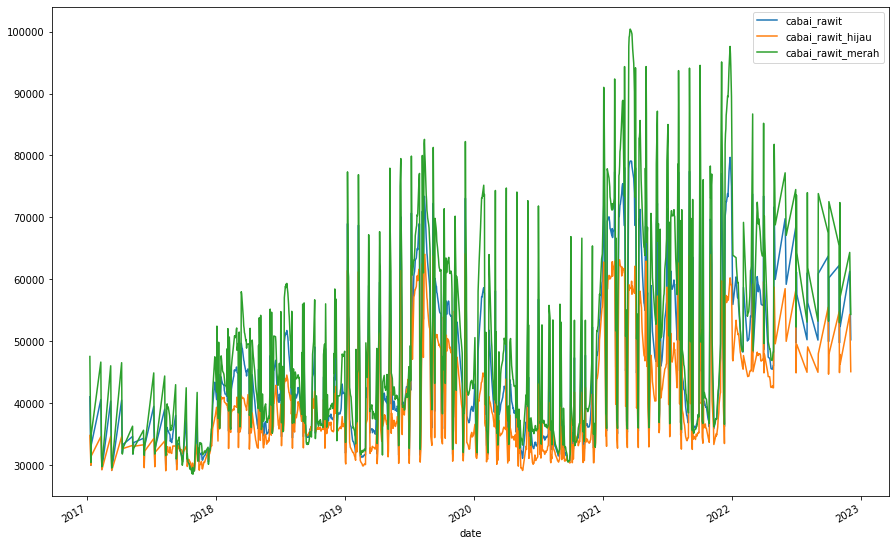

In [25]:
dataset.iloc[:, 21:24].plot(figsize=(15, 10))

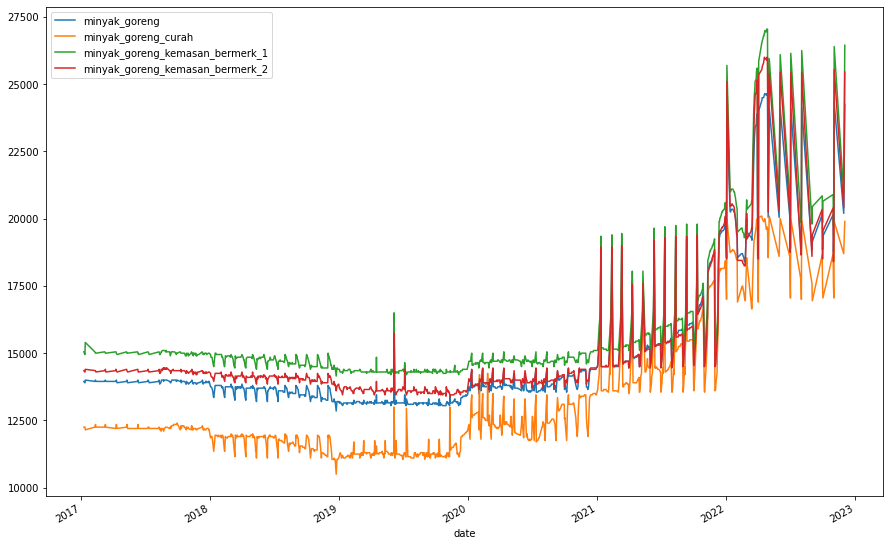

In [26]:
dataset.iloc[:, 24:28].plot(figsize=(15, 10))

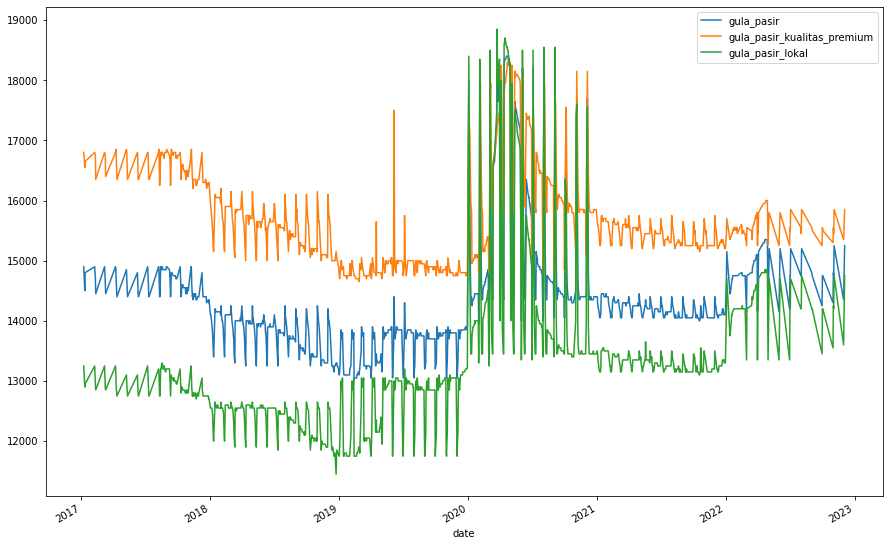

In [27]:
dataset.iloc[:, 28:33].plot(figsize=(15, 10))

In [28]:
dataset.describe()

,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam,daging_ayam_ras_segar,daging_sapi,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,...,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,11745.400341,10691.950596,10337.734242,11798.892675,11608.091993,13056.686542,12636.328790,34411.158433,34411.158433,118751.959114,...,45195.272572,40424.318569,49690.076661,14594.080068,13023.083475,15562.095400,14889.948893,14301.660988,15639.054514,13301.149915
std,161.949867,175.991729,183.281105,172.942935,170.171485,124.202522,138.229818,2411.780873,2411.780873,3981.499790,...,12212.892761,8911.211326,15902.695298,2228.781040,2173.037608,2258.287427,2245.905889,933.874795,751.271642,1241.099926
min,10700.000000,9650.000000,8500.000000,11200.000000,10950.000000,12250.000000,11850.000000,28350.000000,28350.000000,112600.000000,...,29050.000000,29100.000000,28550.000000,12850.000000,10500.000000,14150.000000,13400.000000,13050.000000,14650.000000,11450.000000
25%,11700.000000,10650.000000,10300.000000,11750.000000,11550.000000,13000.000000,12600.000000,32600.000000,32600.000000,115700.000000,...,35750.000000,33600.000000,37150.000000,13400.000000,11550.000000,14500.000000,13850.000000,13800.000000,15100.000000,12550.000000
50%,11750.000000,10700.000000,10350.000000,11800.000000,11600.000000,13050.000000,12650.000000,34350.000000,34350.000000,118100.000000,...,41300.000000,37350.000000,44750.000000,13750.000000,12200.000000,14825.000000,14150.000000,14100.000000,15500.000000,13150.000000
75%,11800.000000,10800.000000,10450.000000,11850.000000,11650.000000,13100.000000,12700.000000,35950.000000,35950.000000,119600.000000,...,53137.500000,45287.500000,59825.000000,14500.000000,13650.000000,15200.000000,14550.000000,14450.000000,15900.000000,13450.000000
max,13100.000000,12500.000000,11000.000000,13250.000000,13250.000000,14000.000000,13600.000000,41300.000000,41300.000000,136600.000000,...,79700.000000,64150.000000,100400.000000,24650.000000,20100.000000,27050.000000,26000.000000,18400.000000,18300.000000,18850.000000


In [29]:
save_desc = dataset.describe().to_csv('data_desc.csv', index = True)
print('\nCSV String:\n', save_desc)


CSV String:
 None


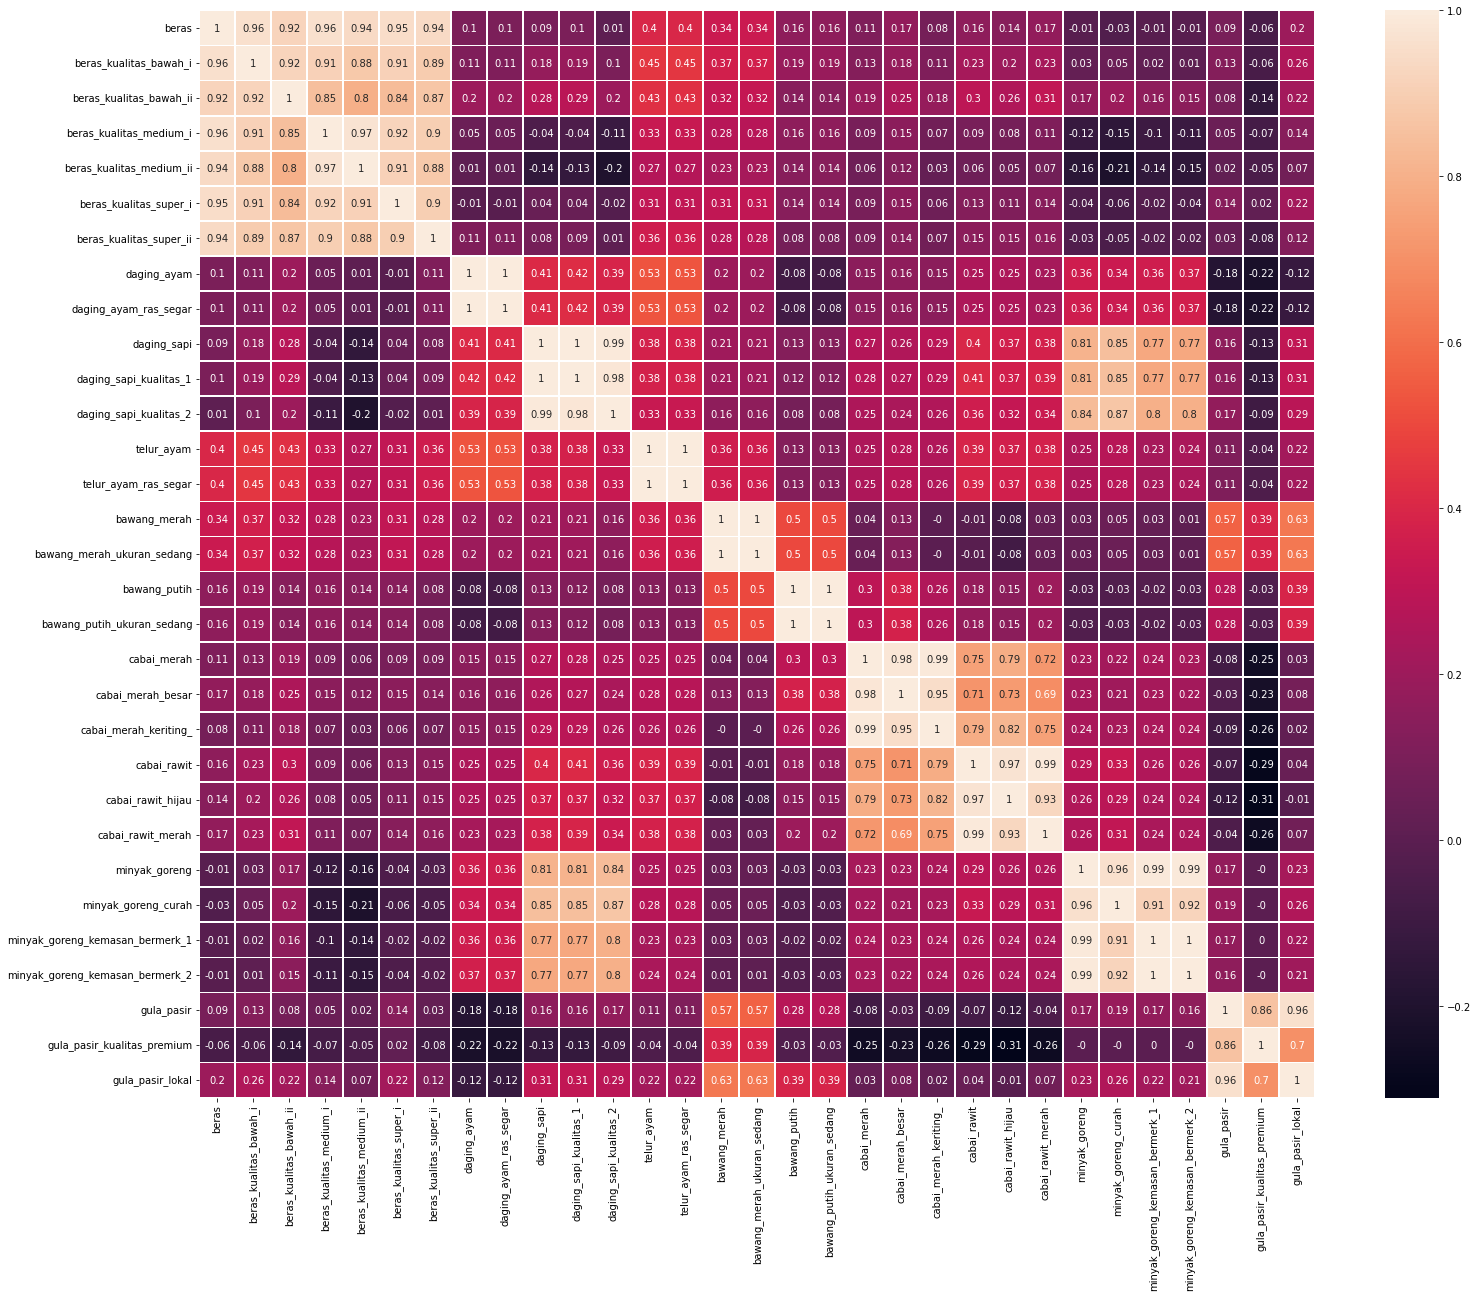

In [30]:
correlation = dataset.corr().round(2)
plt.figure(figsize=(25, 20))
sns.heatmap(data= correlation, annot=True, linewidths=0.7)

berdasarkan tabel correlation diketahui data dengan jenis komodiatas yang berbeda, misalkan beras dengan bawang merah tidak memiliki corelasi yang sama, namun bawang merah dengan bawang merah ukuran sedang memiliki corelasi, jadi perlu di cek apakah datanya sama atau tidak.

In [31]:
dataset.duplicated().value_counts()

False    1169
True        5
dtype: int64

In [32]:
dataset.loc[dataset.duplicated()]

,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam,daging_ayam_ras_segar,daging_sapi,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
date,,,,,,,,,,,,,,,,,,,,,
2018-05-31,11700,10600,10250,11850,11650,13000,12600,35100,35100,115450,...,35400,33900,37550,13700,11900,14850,14100,13950,15700,12550
2018-06-14,11650,10500,10250,11800,11600,12950,12600,38850,38850,122250,...,45400,40050,50850,13600,11850,14700,14050,13900,15550,12550
2018-06-27,11700,10600,10300,11850,11600,13000,12600,37850,37850,116250,...,40350,36450,44100,13700,11900,14750,14150,13900,15650,12550
2019-05-06,11700,10600,10250,11750,11550,13000,12600,38500,38500,126350,...,46000,43550,48400,13150,11250,14300,13600,13900,15050,13050
2022-04-29,11850,10700,10400,11800,11600,13100,13000,40350,40350,136600,...,46050,42500,48250,24600,19650,27050,26000,15350,16000,14850


In [33]:
dataset.drop_duplicates(inplace=True)

In [34]:
dataset.duplicated().value_counts()

False    1169
dtype: int64

In [35]:
len(dataset)

1169

In [36]:
duplicated_daging_ayam = dataset.duplicated(subset=['daging_ayam', 'daging_ayam_ras_segar']).value_counts()
duplicated_bawang_merah = dataset.duplicated(subset=['bawang_merah', 'bawang_merah_ukuran_sedang']).value_counts()
duplicated_bawang_putih = dataset.duplicated(subset=['bawang_putih', 'bawang_putih_ukuran_sedang']).value_counts()
duplicated_telur_ayam = dataset.duplicated(subset=['telur_ayam', 'telur_ayam_ras_segar']).value_counts()
duplicated_daging_sapi = data_pangan.duplicated(subset=['daging_sapi', 'daging_sapi_kualitas_1']).value_counts()
duplicated_minyak_goreng = data_pangan.duplicated(subset=['minyak_goreng_kemasan_bermerk_1', 'minyak_goreng_kemasan_bermerk_2']).value_counts()

print(f'jumlah duplikasi data antara daging ayam dengan daging ayam ras Segar: \n{duplicated_daging_ayam}')
print(f'jumlah duplikasi data antara data bawang merah dengan bawang merah ukuran sedang: \n{duplicated_bawang_merah}')
print(f'jumlah data duplikasi antara bawang putih dengan bawang putih ukuran sedang:\n{duplicated_bawang_putih}')
print(f'jumlah data duplikasi antara telur ayam ras segar dengan sub komoditas telur ayam:\n{duplicated_telur_ayam}')
print(f'jumlah data duplikasi antara daging sapi dengan sub komoditas daging sapi kualitas 1:\n{duplicated_daging_sapi}')
print(f'jumlah data duplikasi antara minyak goreng merk 1 dengan sub komoditas minyak minyak goreng merk 2:\n{duplicated_minyak_goreng}')

jumlah duplikasi data antara daging ayam dengan daging ayam ras Segar: 
True     953
False    216
dtype: int64
jumlah duplikasi data antara data bawang merah dengan bawang merah ukuran sedang: 
True     755
False    414
dtype: int64
jumlah data duplikasi antara bawang putih dengan bawang putih ukuran sedang:
True     807
False    362
dtype: int64
jumlah data duplikasi antara telur ayam ras segar dengan sub komoditas telur ayam:
True     1024
False     145
dtype: int64
jumlah data duplikasi antara daging sapi dengan sub komoditas daging sapi kualitas 1:
False    587
True     587
dtype: int64
jumlah data duplikasi antara minyak goreng merk 1 dengan sub komoditas minyak minyak goreng merk 2:
True     883
False    291
dtype: int64


Setelah dilakukan pengecekan data, data satu komoditas memiliki beberapa duplikasi data namun tidak secara keseluruhan, tetapi untuk itu dalam penelitian ini untuk dataset tersebut maka akan digunakan salah satunya kecuali minyak goreng bermerk 1 dan 2, akan digunakan dua-duanya

In [37]:
dataset = dataset.drop(['bawang_merah', 'bawang_putih', 'daging_ayam','daging_sapi', 'telur_ayam'], axis=1)
dataset

,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,daging_sapi_kualitas_2,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
date,,,,,,,,,,,,,,,,,,,,,
2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,111550,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,109850,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,113650,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,111550,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,111150,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02,11800,10750,10500,11800,11600,13100,12650,35650,128700,119350,...,49750,44950,53000,18750,17500,19750,18400,14800,15550,14250
2022-11-03,11800,10750,10450,11800,11600,13100,12650,36250,130950,121850,...,60250,47900,72400,19350,17050,20600,19550,14750,15450,14200
2022-11-04,11800,10700,10450,11800,11600,13100,12650,37500,133850,124200,...,52400,46350,57200,24300,19900,26400,25550,15250,15850,14750


In [38]:
len(dataset)

1169

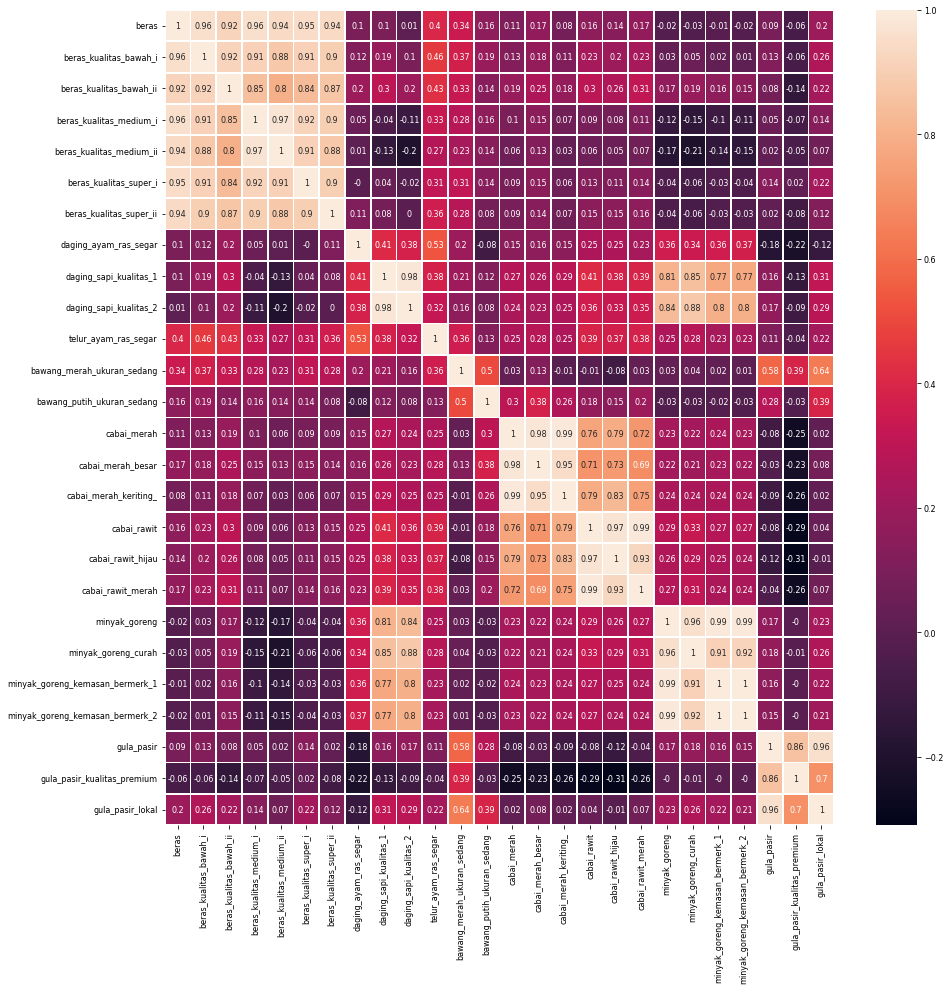

In [39]:
correlation1 = dataset.corr().round(2)
plt.figure(figsize=(15, 15))
plt.rcParams.update({'font.size': 8})
sns.heatmap(data= correlation1, annot=True, linewidths=0.8)

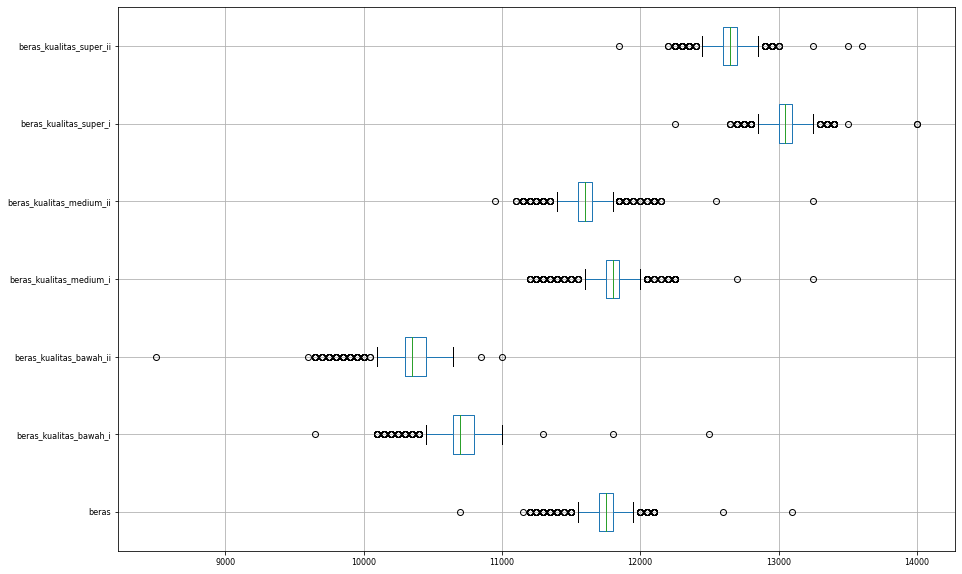

In [40]:
dataset.iloc[:, 0:7].boxplot(figsize=(15, 10), vert=False)

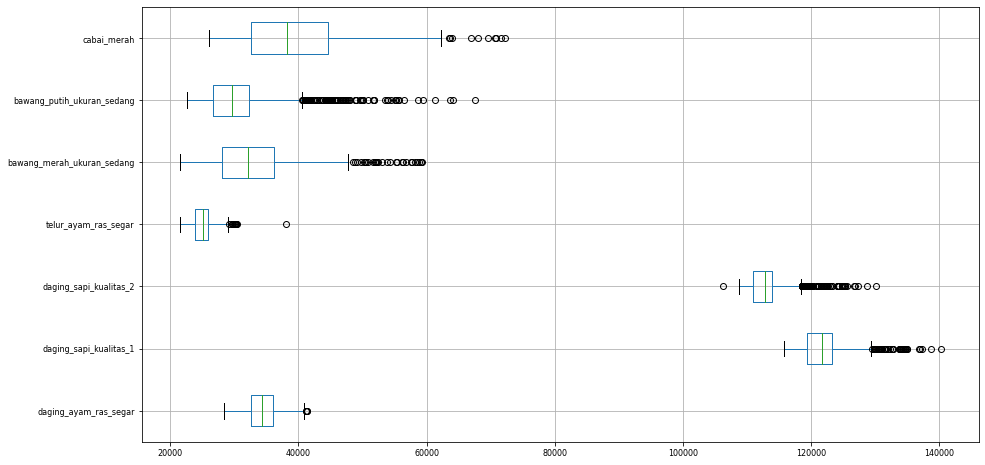

In [41]:
dataset.iloc[:, 7:14].boxplot(figsize=(15, 8), vert=False)

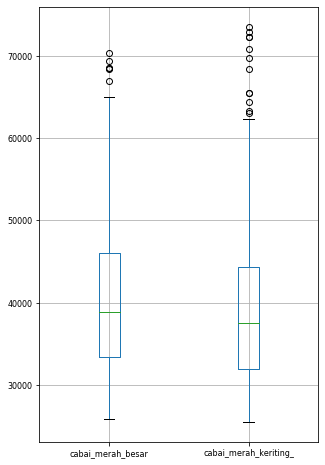

In [42]:
dataset.iloc[:, 14:16].boxplot(figsize=(5, 8))

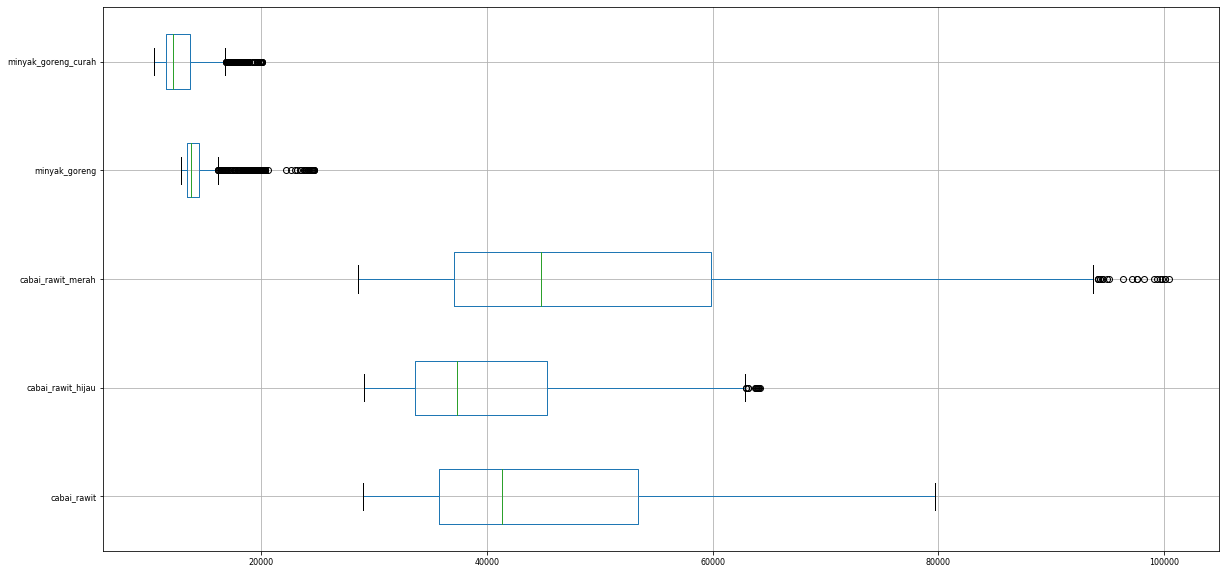

In [43]:
dataset.iloc[:, 16:21].boxplot(figsize=(20, 10), vert=False)

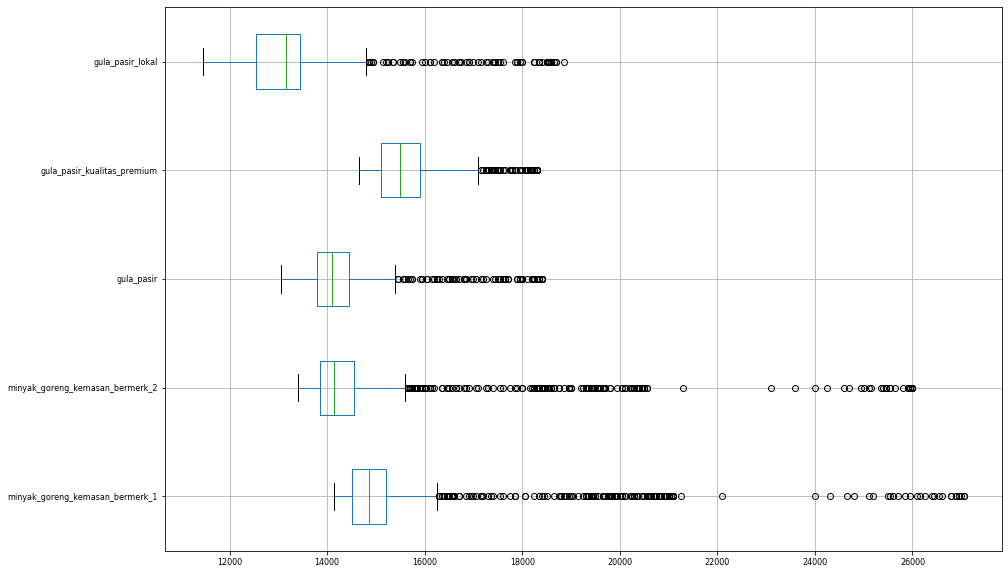

In [44]:
dataset.iloc[:, 21: 27].boxplot(figsize=(15, 10), vert=False)

## Data Processing
setelah di pahami dan di visualisasi ternyata data memiliki nama kolom yang sulit dimengerti maka diperlukan, pergantian nama kolom seperti (kg) dihapus, huruf upper(besar/kapital) diganti lower(kecil) supaya lebih seragam, spasi diganti dengan underscore(_), bertujuan untuk memudahkan pemanggilan kolom untuk langkah selanjutnya

In [62]:
save_desc = dataset.to_csv('data_new.csv', index = True)
print('\nCSV String:\n', save_desc)


CSV String:
 None


In [63]:
# data_pangan.columns = data_pangan.columns.str.replace(' (kg)', '', regex=False).str.replace('(kg)', '', regex=False).str.replace(' ', '_').str.lower()
# data_pangan['date'] = pd.to_datetime(data_pangan.date)
# data_pangan

In [64]:
import scipy.stats as stats
Q1 = data_pangan.quantile(q=.25)
Q3 = data_pangan.quantile(q=.75)
IQR = Q3-Q1

low = Q1-1.5*IQR
high = Q3+1.5*IQR

IQRs = data_pangan.apply(stats.iqr)

lows = Q1-1.5*IQRs
highs = Q3+1.5*IQRs

# clean = data_pangan[~((data_pangan < lows) | (data_pangan > highs)).any(axis=1)]

# out_bawang_putih = data_pangan.bawang_putih.loc[(data_pangan['bawang_putih'] > low) & (data_pangan['bawang_putih'] < high)]

In [65]:
beras = dataset['beras'].values
beras_kualitas_bawah_i = dataset.beras_kualitas_bawah_i.values
beras_kualitas_bawah_ii = dataset.beras_kualitas_bawah_ii.values
beras_kualitas_medium_i = dataset.beras_kualitas_medium_i.values
beras_kualitas_medium_ii = dataset.beras_kualitas_medium_ii.values
beras_kualitas_super_i = dataset.beras_kualitas_super_i.values
beras_kualitas_super_ii = dataset.beras_kualitas_super_ii.values

# daging_ayam = dataset.daging_ayam.values
daging_ayam_ras_segar = dataset.daging_ayam_ras_segar.values

# daging_sapi = dataset.daging_sapi.values
daging_sapi_kualitas_1 = dataset.daging_sapi_kualitas_1.values
daging_sapi_kualitas_2 = dataset.daging_sapi_kualitas_2.values

# telur_ayam = dataset.telur_ayam.values
telur_ayam_ras_segar = dataset.telur_ayam_ras_segar.values

# bawang_merah = dataset.bawang_merah.values
bawang_merah_ukuran_sedang = dataset.bawang_merah_ukuran_sedang.values

# bawang_putih = dataset.bawang_putih.values
bawang_putih_ukuran_sedang = dataset.bawang_putih_ukuran_sedang.values

cabai_merah = dataset.cabai_merah.values
cabai_merah_besar = dataset.cabai_merah_besar.values
cabai_merah_keriting = dataset.cabai_merah_keriting_.values

cabai_rawit = dataset.cabai_rawit.values
cabai_rawit_hijau = dataset.cabai_rawit_hijau.values
cabai_rawit_merah = dataset.cabai_rawit_merah.values

minyak_goreng = dataset.minyak_goreng.values
minyak_goreng_curah = dataset.minyak_goreng_curah.values
minyak_goreng_kemasan_bermerk_1 = dataset.minyak_goreng_kemasan_bermerk_1.values
minyak_goreng_kemasan_bermerk_2 = dataset.minyak_goreng_kemasan_bermerk_2.values

gula_pasir = dataset.gula_pasir.values
gula_pasir_kualitas_premium = dataset.gula_pasir_kualitas_premium.values
gula_pasir_lokal = dataset.gula_pasir_lokal.values
date = dataset.index.values

In [76]:
test_size = 0.2
val_size = 0.1
batch_size_train = 10
batch_size_test= 10
batch_size_val = 5

# windows_size_train5= 100
# windows_size_test= 20
# windows_size_val= 10

# windows_size_train5= 300
# windows_size_test= 100
# windows_size_val= 80

# windows_size_train5= 600
# windows_size_test= 100
# windows_size_val= 80

windows_size_train= 600
windows_size_test= 100
windows_size_val= 80

shuffle_size = 1000

### Split data

In [77]:
x_train_beras, x_test_beras, y_train_beras, y_test_beras= train_test_split(
    beras, date, test_size=test_size, random_state=False, shuffle=False)
x_train_beras, x_val_beras, y_train_beras, y_val_beras = train_test_split(
    x_train_beras, y_train_beras, test_size=val_size, random_state=False, shuffle=False)

x_train_cabai_rawit, x_test_cabai_rawit, y_train_cabai_rawit, y_test_cabai_rawit = train_test_split(
    cabai_rawit, date, test_size=test_size, random_state=False, shuffle=False)
x_train_cabai_rawit, x_val_cabai_rawit, y_train_cabai_rawit, y_val_cabai_rawit = train_test_split(
    x_train_cabai_rawit, y_train_cabai_rawit, test_size=val_size, random_state=False, shuffle=False)

x_train_beras_kualitas_bawah_i, x_test_beras_kualitas_bawah_i, y_train_beras_kualitas_bawah_i, y_beras_kualitas_bawah_i = train_test_split(
    beras_kualitas_bawah_i, date, test_size=test_size, random_state=False, shuffle=False)
x_train_beras_kualitas_bawah_i, x_val_beras_kualitas_bawah_i, y_train_beras_kualitas_bawah_i, y_val_beras_kualitas_bawah_i = train_test_split(
    x_train_beras_kualitas_bawah_i, y_train_beras_kualitas_bawah_i, test_size=val_size, random_state=False, shuffle=False)

x_train_beras_kualitas_bawah_ii, x_test_beras_kualitas_bawah_ii, y_train_beras_kualitas_bawah_i, y_test_beras_kualitas_bawah_i= train_test_split(
    beras_kualitas_bawah_ii, date, test_size=test_size, random_state=False, shuffle=False)
x_train_beras_kualitas_bawah_ii, x_val_beras_kualitas_bawah_ii, y_train_beras_kualitas_bawah_i, y_val_beras_kualitas_bawah_i = train_test_split(
    x_train_beras, y_train_beras, test_size=val_size, random_state=False, shuffle=False)

x_train_beras_kualitas_medium_i, x_test_beras_kualitas_medium_i, y_train_beras_kualitas_medium_i, y_test_beras_kualitas_medium_i = train_test_split(
    beras_kualitas_medium_i, date, test_size=test_size, random_state=False, shuffle=False)
x_train_beras_kualitas_medium_i, x_val_beras_kualitas_medium_i, y_train_beras_kualitas_medium_i, y_val_beras_kualitas_medium_i  = train_test_split(
    x_train_beras_kualitas_medium_i, y_train_beras_kualitas_medium_i, test_size=val_size, random_state=False, shuffle=False)

x_train_beras_kualitas_medium_ii, x_test_beras_kualitas_medium_ii, y_train_beras_kualitas_medium_ii, y_test_beras_kualitas_medium_ii = train_test_split(
    beras_kualitas_medium_i, date, test_size=test_size, random_state=False, shuffle=False)
x_train_beras_kualitas_medium_ii, x_val_beras_kualitas_medium_ii, y_train_beras_kualitas_medium_ii, y_val_beras_kualitas_medium_ii = train_test_split(
    x_train_beras_kualitas_medium_ii, y_train_beras_kualitas_medium_ii, test_size=val_size, random_state=False, shuffle=False)

x_train_beras_kualitas_super_i, x_test_beras_kualitas_super_i, y_train_beras_kualitas_super_i, y_test_beras_kualitas_super_i= train_test_split(
    beras_kualitas_super_i, date, test_size=test_size, random_state=False, shuffle=False)
x_train_beras_kualitas_super_i, x_val_beras_kualitas_super_i, y_train_bberas_kualitas_super_i, y_val_beras_kualitas_super_i = train_test_split(
    x_train_beras_kualitas_super_i, y_train_beras_kualitas_super_i, test_size=val_size, random_state=False, shuffle=False)

x_train_beras_kualitas_super_ii, x_test_beras_kualitas_super_ii, y_train_beras_kualitas_super_ii, y_test_beras_kualitas_super_ii= train_test_split(
    beras_kualitas_super_i, date, test_size=test_size, random_state=False, shuffle=False)
x_train_beras_kualitas_super_ii, x_val_beras_kualitas_super_ii, y_train_beras_kualitas_super_ii, y_val_beras_kualitas_super_ii = train_test_split(
    x_train_beras_kualitas_super_ii, y_train_beras_kualitas_super_ii, test_size=val_size, random_state=False, shuffle=False)

# x_train_daging_ayam, x_test_daging_ayam, y_train_daging_ayam, y_test_daging_ayam= train_test_split(
#     daging_ayam, date, test_size=test_size, random_state=False, shuffle=False)
# x_train_daging_ayam, x_val_daging_ayam, y_train_daging_ayam, y_val_daging_ayam = train_test_split(
#     x_train_daging_ayam, y_train_daging_ayam, test_size=val_size, random_state=False, shuffle=False)

x_train_daging_ayam_ras_segar, x_test_daging_ayam_ras_segar, y_train_daging_ayam_ras_segar, y_test_daging_ayam_ras_segar= train_test_split(
    daging_ayam_ras_segar, date, test_size=test_size, random_state=False, shuffle=False)
x_train_daging_ayam_ras_segar, x_val_daging_ayam_ras_segar, y_train_daging_ayam_ras_segar, y_val_daging_ayam_ras_segar = train_test_split(
    x_train_daging_ayam_ras_segar, y_train_daging_ayam_ras_segar, test_size=val_size, random_state=False, shuffle=False)

# x_train_bawang_merah, x_test_bawang_merah, y_train_bawang_merah, y_test_bawang_merah= train_test_split(
#     bawang_merah, date, test_size=test_size, random_state=False, shuffle=False)
# x_train_bawang_merah, x_val_bawang_merah, y_train_bawang_merah, y_val_bawang_merah = train_test_split(
#     x_train_bawang_merah, y_train_bawang_merah, test_size=val_size, random_state=False, shuffle=False)

x_train_bawang_merah_ukuran_sedang, x_test_bawang_merah_ukuran_sedang, y_train_bawang_merah_ukuran_sedang, y_test_bawang_merah_ukuran_sedang= train_test_split(
    bawang_merah_ukuran_sedang, date, test_size=0.2, random_state=False, shuffle=False)
x_train_bawang_merah_ukuran_sedang, x_val_bawang_merah_ukuran_sedang, y_train_bawang_merah_ukuran_sedang, y_val_bawang_merah_ukuran_sedang = train_test_split(
    x_train_bawang_merah_ukuran_sedang, y_train_bawang_merah_ukuran_sedang, test_size=val_size, random_state=False, shuffle=False)

# x_train_bawang_putih, x_test_bawang_putih, y_train_bawang_putih, y_test_bawang_putih= train_test_split(
#     bawang_putih, date, test_size=test_size, random_state=False, shuffle=False)
# x_train_bawang_putih, x_val_bawang_putih, y_train_bawang_putih, y_val_bawang_putih= train_test_split(
#     x_train_bawang_putih, y_train_bawang_putih, test_size=val_size, random_state=False, shuffle=False)

x_train_bawang_putih_ukuran_sedang, x_test_bawang_putih_ukuran_sedang, y_train_bawang_putih_ukuran_sedang, y_test_bawang_putih_ukuran_sedang = train_test_split(
    bawang_putih_ukuran_sedang, date, test_size=test_size, random_state=False, shuffle=False)
x_train_bawang_putih_ukuran_sedang, x_val_bawang_putih_ukuran_sedang, y_train_bawang_putih_ukuran_sedang, y_val_bawang_putih_ukuran_sedang = train_test_split(
    x_train_bawang_putih_ukuran_sedang, y_train_bawang_putih_ukuran_sedang, test_size=val_size, random_state=False, shuffle=False)

# x_train_daging_sapi, x_test_daging_sapi, y_train_daging_sapi, y_test_daging_sapi= train_test_split(
#     daging_sapi, date, test_size=test_size, random_state=False, shuffle=False)
# x_train_daging_sapi, x_val_daging_sapi, y_train_daging_sapi, y_val_daging_sapi = train_test_split(
#     x_train_daging_sapi, y_train_daging_sapi, test_size=val_size, random_state=False, shuffle=False)

x_train_daging_sapi_kualitas_1, x_test_daging_sapi_kualitas_1, y_train_daging_sapi_kualitas_1, y_test_daging_sapi_kualitas_1 = train_test_split(
    daging_sapi_kualitas_1, date, test_size=test_size, random_state=False, shuffle=False)
x_train_daging_sapi_kualitas_1, x_val_daging_sapi_kualitas_1, y_train_daging_sapi_kualitas_1, y_val_daging_sapi_kualitas_1 = train_test_split(
    x_train_daging_sapi_kualitas_1, y_train_daging_sapi_kualitas_1, test_size=val_size, random_state=False, shuffle=False)

x_train_daging_sapi_kualitas_2, x_test_daging_sapi_kualitas_2, y_train_daging_sapi_kualitas_2, y_test_daging_sapi_kualitas_2 = train_test_split(
    daging_sapi_kualitas_2, date, test_size=test_size, random_state=False, shuffle=False)
x_train_daging_sapi_kualitas_2, x_val_daging_sapi_kualitas_2, y_train_daging_sapi_kualitas_2, y_val_daging_sapi_kualitas_2 = train_test_split(
    x_train_daging_sapi_kualitas_2, y_train_daging_sapi_kualitas_2, test_size=val_size, random_state=False, shuffle=False)

# x_train_telur_ayam, x_test_telur_ayam, y_train_telur_ayam, y_test_telur_ayam= train_test_split(
#     telur_ayam, date, test_size=test_size, random_state=False, shuffle=False)
# x_train_telur_ayam, x_val_telur_ayam, y_train_telur_ayam, y_val_telur_ayam = train_test_split(
#     x_train_telur_ayam, y_train_telur_ayam, test_size=val_size, random_state=False, shuffle=False)

x_train_telur_ayam_ras_segar, x_test_telur_ayam_ras_segar, y_train_telur_ayam_ras_segar, y_test_telur_ayam_ras_segar= train_test_split(
    telur_ayam_ras_segar, date, test_size=test_size, random_state=False, shuffle=False)
x_train_telur_ayam_ras_segar, x_val_telur_ayam_ras_segar, y_train_telur_ayam_ras_segar, y_val_telur_ayam_ras_segar = train_test_split(
    x_train_telur_ayam_ras_segar, y_train_telur_ayam_ras_segar, test_size=val_size, random_state=False, shuffle=False)

x_train_cabai_merah, x_test_cabai_merah, y_train_cabai_merah, y_test_cabai_merah= train_test_split(
    cabai_merah, date, test_size=test_size, random_state=False, shuffle=False)
x_train_cabai_merah, x_val_cabai_merah, y_train_cabai_merah, y_val_cabai_merah = train_test_split(
    x_train_cabai_merah, y_train_cabai_merah, test_size=val_size, random_state=False, shuffle=False)

x_train_cabai_merah_besar, x_test_cabai_merah_besar, y_train_cabai_merah_besar, y_test_cabai_merah_besar= train_test_split(
    cabai_merah_besar, date, test_size=test_size, random_state=False, shuffle=False)
x_train_cabai_merah_besar, x_val_cabai_merah_besar, y_train_cabai_merah_besar, y_val_cabai_merah_besar = train_test_split(
    x_train_cabai_merah_besar, y_train_cabai_merah_besar, test_size=0.1, random_state=False, shuffle=False)

x_train_cabai_merah_keriting, x_test_cabai_merah_keriting, y_train_cabai_merah_keriting, y_test_cabai_merah_keriting= train_test_split(
    cabai_merah_keriting, date, test_size=test_size, random_state=False, shuffle=False)
x_train_cabai_merah_keriting, x_val_cabai_merah_keriting, y_train_cabai_merah_keriting, y_val_cabai_merah_keriting= train_test_split(
    x_train_cabai_merah_keriting, y_train_cabai_merah_keriting, test_size=val_size, random_state=False, shuffle=False)

x_train_minyak_goreng, x_test_minyak_goreng, y_train_minyak_goreng, y_test_minyak_goreng= train_test_split(
    minyak_goreng, date, test_size=test_size, random_state=False, shuffle=False)
x_train_minyak_goreng, x_val_minyak_goreng, y_train_minyak_goreng, y_val_minyak_goreng = train_test_split(
    x_train_minyak_goreng, y_train_minyak_goreng, test_size=val_size, random_state=False, shuffle=False)

x_train_minyak_goreng_curah, x_test_minyak_goreng_curah, y_train_minyak_goreng_curah, y_test_minyak_goreng_curah= train_test_split(
    minyak_goreng_curah, date, test_size=test_size, random_state=False, shuffle=False)
x_train_minyak_goreng_curah, x_val_minyak_goreng_curah, y_train_minyak_goreng_curah, y_val_minyak_goreng_curah = train_test_split(
    x_train_minyak_goreng_curah, y_train_minyak_goreng_curah, test_size=val_size, random_state=False, shuffle=False)

x_train_minyak_goreng_kemasan_bermerk_1, x_test_minyak_goreng_kemasan_bermerk_1, y_train_minyak_goreng_kemasan_bermerk_1, y_test_minyak_goreng_kemasan_bermerk_1= train_test_split(
    minyak_goreng_kemasan_bermerk_1, date, test_size=test_size, random_state=False, shuffle=False)
x_train_minyak_goreng_kemasan_bermerk_1, x_val_minyak_goreng_kemasan_bermerk_1, y_train_minyak_goreng_kemasan_bermerk_1, y_val_minyak_goreng_bermerek_1 = train_test_split(
    x_train_minyak_goreng_kemasan_bermerk_1, y_train_minyak_goreng_kemasan_bermerk_1, test_size=val_size, random_state=False, shuffle=False)

x_train_minyak_goreng_kemasan_bermerk_2, x_test_minyak_goreng_kemasan_bermerk_2, y_train_minyak_goreng_kemasan_bermerk_2, y_test_minyak_goreng_kemasan_bermerk_2= train_test_split(
    minyak_goreng_kemasan_bermerk_2, date, test_size=test_size, random_state=False, shuffle=False)
x_train_minyak_goreng_kemasan_bermerk_2, x_val_minyak_goreng_kemasan_bermerk_2, y_train_minyak_goreng_kemasan_bermerk_2, y_val_minyak_goreng_kemasan_bermerk_2 = train_test_split(
    x_train_minyak_goreng_kemasan_bermerk_2, y_train_minyak_goreng_kemasan_bermerk_2, test_size=val_size, random_state=False, shuffle=False)

x_train_gula_pasir, x_test_gula_pasir, y_train_gula_pasir, y_test_gula_pasir= train_test_split(
    gula_pasir, date, test_size=test_size, random_state=False, shuffle=False)
x_train_gula_pasir, x_val_gula_pasir, y_train_gula_pasir, y_val_gula_pasir = train_test_split(
    x_train_gula_pasir, y_train_gula_pasir, test_size=val_size, random_state=False, shuffle=False)

x_train_gula_pasir_kualitas_premium , x_test_gula_pasir_kualitas_premium, y_train_gula_pasir_kualitas_premium, y_test_gula_pasir_kualitas_premium= train_test_split(
    gula_pasir_kualitas_premium, date, test_size=test_size, random_state=False, shuffle=False)
x_train_gula_pasir_kualitas_premium, x_val_gula_pasir_kualitas_premium, y_train_gula_pasir_kualitas_premium, y_val_gula_pasir_kualitas_premium = train_test_split(
    x_train_gula_pasir_kualitas_premium, y_train_gula_pasir_kualitas_premium, test_size=val_size, random_state=False, shuffle=False)

x_train_gula_pasir_lokal, x_test_gula_pasir_lokal, y_train_gula_pasir_lokal, y_test_gula_pasir_lokal= train_test_split(
    gula_pasir_lokal, date, test_size=test_size, random_state=False, shuffle=False)
x_train_gula_pasir_lokal, x_val_gula_pasir_lokal, y_train_gula_pasir_lokal, y_val_gula_pasir_lokal = train_test_split(
    x_train_gula_pasir_lokal, y_train_gula_pasir_lokal, test_size=val_size, random_state=False, shuffle=False)

x_train_cabai_rawit_hijau, x_test_cabai_rawit_hijau, y_train_cabai_rawit_hijau, y_test_cabai_rawit_hijau= train_test_split(
    cabai_rawit_hijau, date, test_size=test_size, random_state=False, shuffle=False)
x_train_cabai_rawit_hijau, x_val_cabai_rawit_hijau, y_train_cabai_rawit_hijau, y_val_cabai_rawit_hijau = train_test_split(
    x_train_cabai_rawit_hijau, y_train_cabai_rawit_hijau, test_size=val_size, random_state=False, shuffle=False)

x_train_cabai_rawit_merah, x_test_cabai_rawit_merah, y_train_cabai_rawit_merah, y_test_cabai_rawit_merah= train_test_split(
    cabai_rawit_merah, date, test_size=test_size, random_state=False, shuffle=False)
x_train_cabai_rawit_merah, x_val_cabai_rawit_merah, y_train_cabai_rawit_merah, y_val_cabai_rawit_merah = train_test_split(
    x_train_cabai_rawit_merah, y_train_cabai_rawit_merah, test_size=val_size, random_state=False, shuffle=False)

In [68]:
len(x_train_cabai_merah),len (x_test_beras), len(x_val_beras)

(841, 234, 94)

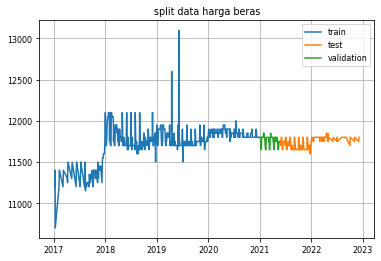

In [69]:
plt.title('split data harga beras')
plt.plot(y_train_beras, x_train_beras, label='train')
plt.plot(y_test_beras, x_test_beras, label='test')
plt.plot(y_val_beras, x_val_beras, label='validation')
plt.legend()
plt.grid()
plt.show()

In [70]:
x_train_beras

array([11200, 11400, 10700, 11200, 11400, 11400, 11200, 11350, 11400,
       11300, 11250, 11350, 11500, 11300, 11400, 11500, 11200, 11400,
       11400, 11500, 11200, 11300, 11400, 11500, 11200, 11300, 11350,
       11500, 11150, 11200, 11250, 11250, 11200, 11200, 11250, 11250,
       11250, 11250, 11250, 11250, 11250, 11200, 11300, 11350, 11300,
       11300, 11300, 11250, 11250, 11350, 11350, 11350, 11350, 11300,
       11400, 11350, 11200, 11400, 11350, 11400, 11400, 11400, 11400,
       11400, 11400, 11300, 11300, 11300, 11400, 11350, 11400, 11350,
       11250, 11300, 11350, 11500, 11400, 11300, 11400, 11400, 11400,
       11400, 11450, 11400, 11400, 11400, 11450, 11450, 11450, 11450,
       11250, 11350, 11500, 11550, 11550, 11550, 11550, 11600, 11600,
       11600, 11600, 11600, 11650, 11700, 12100, 12000, 11700, 11700,
       11700, 11750, 11950, 12000, 12000, 12050, 12050, 12050, 12050,
       12100, 12100, 12100, 12100, 12100, 12100, 11750, 12100, 12000,
       11900, 11750,

### MinMaxScaller

In [71]:
scaller = MinMaxScaler(feature_range=(0, 1))

x_trains_beras = scaller.fit_transform(x_train_beras.reshape(-1, 1))
x_trains_beras_kualitas_bawah_i = scaller.fit_transform(x_train_beras_kualitas_bawah_i.reshape(-1, 1))
x_trains_beras_kualitas_bawah_ii = scaller.fit_transform(x_train_beras_kualitas_bawah_ii.reshape(-1, 1))
x_trains_beras_kualitas_medium_i = scaller.fit_transform(x_train_beras_kualitas_medium_i.reshape(-1, 1))
x_trains_beras_kualitas_medium_ii = scaller.fit_transform(x_train_beras_kualitas_medium_ii.reshape(-1, 1))
x_trains_beras_kualitas_super_i = scaller.fit_transform(x_train_beras_kualitas_super_i.reshape(-1, 1))
x_trains_beras_kualitas_super_ii = scaller.fit_transform(x_train_beras_kualitas_super_ii.reshape(-1, 1))

# x_trains_daging_ayam = scaller.fit_transform(x_train_daging_ayam.reshape(-1, 1))
x_trains_daging_ayam_ras_segar = scaller.fit_transform(x_train_daging_ayam_ras_segar.reshape(-1, 1))

# x_trains_daging_sapi= scaller.fit_transform(x_train_daging_sapi.reshape(-1, 1))
x_trains_daging_sapi_kualitas_1 = scaller.fit_transform(x_train_daging_sapi_kualitas_1.reshape(-1, 1))
x_trains_daging_sapi_kualitas_2 = scaller.fit_transform(x_train_daging_sapi_kualitas_2.reshape(-1, 1))

# x_trains_telur_ayam = scaller.fit_transform(x_train_telur_ayam.reshape(-1, 1))
x_trains_telur_ayam_ras_segar = scaller.fit_transform(x_train_telur_ayam_ras_segar.reshape(-1, 1))

# x_trains_bawang_merah = scaller.fit_transform(x_train_bawang_merah.reshape(-1, 1))
x_trains_bawang_merah_ukuran_sedang = scaller.fit_transform(x_train_bawang_merah_ukuran_sedang.reshape(-1, 1))

# x_trains_bawang_putih = scaller.fit_transform(x_train_bawang_putih.reshape(-1, 1))
x_trains_bawang_putih_ukuran_sedang= scaller.fit_transform(x_train_bawang_putih_ukuran_sedang.reshape(-1, 1))

x_trains_cabai_merah = scaller.fit_transform(x_train_cabai_merah.reshape(-1, 1))
x_trains_cabai_merah_besar = scaller.fit_transform(x_train_cabai_merah_besar.reshape(-1, 1))
x_trains_cabai_merah_keriting = scaller.fit_transform(x_train_cabai_merah_keriting.reshape(-1, 1))

x_trains_cabai_rawit = scaller.fit_transform(x_train_cabai_rawit.reshape(-1, 1))
x_trains_cabai_rawit_hijau = scaller.fit_transform(x_train_cabai_rawit_hijau.reshape(-1, 1))
x_trains_cabai_rawit_merah= scaller.fit_transform(x_train_cabai_rawit_merah.reshape(-1, 1))

x_trains_minyak_goreng = scaller.fit_transform(x_train_minyak_goreng.reshape(-1, 1))
x_trains_minyak_goreng_curah = scaller.fit_transform(x_train_minyak_goreng_curah.reshape(-1, 1))
x_trains_minyak_goreng_kemasan_bermerk_1 = scaller.fit_transform(x_train_minyak_goreng_kemasan_bermerk_1.reshape(-1, 1))
x_trains_minyak_goreng_kemasan_bermerk_2 = scaller.fit_transform(x_train_minyak_goreng_kemasan_bermerk_2.reshape(-1, 1))

x_trains_gula_pasir = scaller.fit_transform(x_train_gula_pasir.reshape(-1, 1))
x_trains_gula_pasir_kualitas_premium = scaller.fit_transform(x_train_gula_pasir_kualitas_premium.reshape(-1, 1))
x_trains_gula_pasir_lokal = scaller.fit_transform(x_train_gula_pasir_lokal.reshape(-1, 1))

In [72]:
print(x_trains_beras)

[[0.20833333]
 [0.29166667]
 [0.        ]
 [0.20833333]
 [0.29166667]
 [0.29166667]
 [0.20833333]
 [0.27083333]
 [0.29166667]
 [0.25      ]
 [0.22916667]
 [0.27083333]
 [0.33333333]
 [0.25      ]
 [0.29166667]
 [0.33333333]
 [0.20833333]
 [0.29166667]
 [0.29166667]
 [0.33333333]
 [0.20833333]
 [0.25      ]
 [0.29166667]
 [0.33333333]
 [0.20833333]
 [0.25      ]
 [0.27083333]
 [0.33333333]
 [0.1875    ]
 [0.20833333]
 [0.22916667]
 [0.22916667]
 [0.20833333]
 [0.20833333]
 [0.22916667]
 [0.22916667]
 [0.22916667]
 [0.22916667]
 [0.22916667]
 [0.22916667]
 [0.22916667]
 [0.20833333]
 [0.25      ]
 [0.27083333]
 [0.25      ]
 [0.25      ]
 [0.25      ]
 [0.22916667]
 [0.22916667]
 [0.27083333]
 [0.27083333]
 [0.27083333]
 [0.27083333]
 [0.25      ]
 [0.29166667]
 [0.27083333]
 [0.20833333]
 [0.29166667]
 [0.27083333]
 [0.29166667]
 [0.29166667]
 [0.29166667]
 [0.29166667]
 [0.29166667]
 [0.29166667]
 [0.25      ]
 [0.25      ]
 [0.25      ]
 [0.29166667]
 [0.27083333]
 [0.29166667]
 [0.27

In [73]:
x_tests_beras = scaller.fit_transform(x_test_beras.reshape(-1, 1))
x_tests_beras_kualitas_bawah_i = scaller.fit_transform(x_test_beras_kualitas_bawah_i.reshape(-1, 1))
x_tests_beras_kualitas_bawah_ii = scaller.fit_transform(x_test_beras_kualitas_bawah_ii.reshape(-1, 1))
x_tests_beras_kualitas_medium_i = scaller.fit_transform(x_test_beras_kualitas_medium_i.reshape(-1, 1))
x_tests_beras_kualitas_medium_ii = scaller.fit_transform(x_test_beras_kualitas_medium_ii.reshape(-1, 1))
x_tests_beras_kualitas_super_i = scaller.fit_transform(x_test_beras_kualitas_super_i.reshape(-1, 1))
x_tests_beras_kualitas_super_ii = scaller.fit_transform(x_test_beras_kualitas_super_ii.reshape(-1, 1))

# x_tests_daging_ayam = scaller.fit_transform(x_test_daging_ayam.reshape(-1, 1))
x_tests_daging_ayam_ras_segar = scaller.fit_transform(x_test_daging_ayam_ras_segar.reshape(-1, 1))

# x_tests_daging_sapi= scaller.fit_transform(x_test_daging_sapi.reshape(-1, 1))
x_tests_daging_sapi_kualitas_1 = scaller.fit_transform(x_test_daging_sapi_kualitas_1.reshape(-1, 1))
x_tests_daging_sapi_kualitas_2 = scaller.fit_transform(x_test_daging_sapi_kualitas_2.reshape(-1, 1))

# x_tests_telur_ayam = scaller.fit_transform(x_test_telur_ayam.reshape(-1, 1))
x_tests_telur_ayam_ras_segar = scaller.fit_transform(x_test_telur_ayam_ras_segar.reshape(-1, 1))

# x_tests_bawang_merah = scaller.fit_transform(x_test_bawang_merah.reshape(-1, 1))
x_tests_bawang_merah_ukuran_sedang = scaller.fit_transform(x_test_bawang_merah_ukuran_sedang.reshape(-1, 1))

# x_tests_bawang_putih = scaller.fit_transform(x_test_bawang_putih.reshape(-1, 1))
x_tests_bawang_putih_ukuran_sedang= scaller.fit_transform(x_test_bawang_putih_ukuran_sedang.reshape(-1, 1))

x_tests_cabai_merah = scaller.fit_transform(x_test_cabai_merah.reshape(-1, 1))
x_tests_cabai_merah_besar = scaller.fit_transform(x_test_cabai_merah_besar.reshape(-1, 1))
x_tests_cabai_merah_keriting = scaller.fit_transform(x_test_cabai_merah_keriting.reshape(-1, 1))

x_tests_cabai_rawit = scaller.fit_transform(x_test_cabai_rawit.reshape(-1, 1))
x_tests_cabai_rawit_hijau = scaller.fit_transform(x_test_cabai_rawit_hijau.reshape(-1, 1))
x_tests_cabai_rawit_merah= scaller.fit_transform(x_test_cabai_rawit_merah.reshape(-1, 1))

x_tests_minyak_goreng = scaller.fit_transform(x_test_minyak_goreng.reshape(-1, 1))
x_tests_minyak_goreng_curah = scaller.fit_transform(x_test_minyak_goreng_curah.reshape(-1, 1))
x_tests_minyak_goreng_kemasan_bermerk_1 = scaller.fit_transform(x_test_minyak_goreng_kemasan_bermerk_1.reshape(-1, 1))
x_tests_minyak_goreng_kemasan_bermerk_2 = scaller.fit_transform(x_test_minyak_goreng_kemasan_bermerk_2.reshape(-1, 1))

x_tests_gula_pasir = scaller.fit_transform(x_test_gula_pasir.reshape(-1, 1))
x_tests_gula_pasir_kualitas_premium = scaller.fit_transform(x_test_gula_pasir_kualitas_premium.reshape(-1, 1))
x_tests_gula_pasir_lokal = scaller.fit_transform(x_test_gula_pasir_lokal.reshape(-1, 1))

In [74]:
x_vals_beras = scaller.fit_transform(x_val_beras.reshape(-1, 1))
x_vals_beras_kualitas_bawah_i = scaller.fit_transform(x_val_beras_kualitas_bawah_i.reshape(-1, 1))
x_vals_beras_kualitas_bawah_ii = scaller.fit_transform(x_val_beras_kualitas_bawah_ii.reshape(-1, 1))
x_vals_beras_kualitas_medium_i = scaller.fit_transform(x_val_beras_kualitas_medium_i.reshape(-1, 1))
x_vals_beras_kualitas_medium_ii = scaller.fit_transform(x_val_beras_kualitas_medium_ii.reshape(-1, 1))
x_vals_beras_kualitas_super_i = scaller.fit_transform(x_val_beras_kualitas_super_i.reshape(-1, 1))
x_vals_beras_kualitas_super_ii = scaller.fit_transform(x_val_beras_kualitas_super_ii.reshape(-1, 1))

# x_vals_daging_ayam = scaller.fit_transform(x_val_daging_ayam.reshape(-1, 1))
x_vals_daging_ayam_ras_segar = scaller.fit_transform(x_val_daging_ayam_ras_segar.reshape(-1, 1))

# x_vals_daging_sapi= scaller.fit_transform(x_val_daging_sapi.reshape(-1, 1))
x_vals_daging_sapi_kualitas_1 = scaller.fit_transform(x_val_daging_sapi_kualitas_1.reshape(-1, 1))
x_vals_daging_sapi_kualitas_2 = scaller.fit_transform(x_val_daging_sapi_kualitas_2.reshape(-1, 1))

# x_vals_telur_ayam = scaller.fit_transform(x_val_telur_ayam.reshape(-1, 1))
x_vals_telur_ayam_ras_segar = scaller.fit_transform(x_val_telur_ayam_ras_segar.reshape(-1, 1))

# x_vals_bawang_merah = scaller.fit_transform(x_val_bawang_merah.reshape(-1, 1))
x_vals_bawang_merah_ukuran_sedang = scaller.fit_transform(x_val_bawang_merah_ukuran_sedang.reshape(-1, 1))

# x_vals_bawang_putih = scaller.fit_transform(x_val_bawang_putih.reshape(-1, 1))
x_vals_bawang_putih_ukuran_sedang= scaller.fit_transform(x_val_bawang_putih_ukuran_sedang.reshape(-1, 1))

x_vals_cabai_merah = scaller.fit_transform(x_val_cabai_merah.reshape(-1, 1))
x_vals_cabai_merah_besar = scaller.fit_transform(x_val_cabai_merah_besar.reshape(-1, 1))
x_vals_cabai_merah_keriting = scaller.fit_transform(x_val_cabai_merah_keriting.reshape(-1, 1))

x_vals_cabai_rawit = scaller.fit_transform(x_val_cabai_rawit.reshape(-1, 1))
x_vals_cabai_rawit_hijau = scaller.fit_transform(x_val_cabai_rawit_hijau.reshape(-1, 1))
x_vals_cabai_rawit_merah= scaller.fit_transform(x_val_cabai_rawit_merah.reshape(-1, 1))

x_vals_minyak_goreng = scaller.fit_transform(x_val_minyak_goreng.reshape(-1, 1))
x_vals_minyak_goreng_curah = scaller.fit_transform(x_val_minyak_goreng_curah.reshape(-1, 1))
x_vals_minyak_goreng_kemasan_bermerk_1 = scaller.fit_transform(x_val_minyak_goreng_kemasan_bermerk_1.reshape(-1, 1))
x_vals_minyak_goreng_kemasan_bermerk_2 = scaller.fit_transform(x_val_minyak_goreng_kemasan_bermerk_2.reshape(-1, 1))

x_vals_gula_pasir = scaller.fit_transform(x_val_gula_pasir.reshape(-1, 1))
x_vals_gula_pasir_kualitas_premium = scaller.fit_transform(x_val_gula_pasir_kualitas_premium.reshape(-1, 1))
x_vals_gula_pasir_lokal = scaller.fit_transform(x_val_gula_pasir_lokal.reshape(-1, 1))

In [75]:
x_vals_gula_pasir.shape

(94, 1)

## Data Preparation

In [132]:
train_beras = time_step_generator(x_trains_beras, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_beras_kualitas_bawah_i = time_step_generator(x_trains_beras_kualitas_bawah_i, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_beras_kualitas_bawah_ii = time_step_generator(x_trains_beras_kualitas_bawah_ii, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_beras_kualitas_medium_i = time_step_generator(x_trains_beras_kualitas_medium_i, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_beras_kualitas_medium_ii = time_step_generator(x_trains_beras_kualitas_medium_ii, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_beras_kualitas_super_i = time_step_generator(x_trains_beras_kualitas_super_i, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_beras_kualitas_super_ii = time_step_generator(x_trains_beras_kualitas_super_ii, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)

# train_daging_ayam = time_step_generator(x_trains_daging_ayam, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_daging_ayam_ras_segar = time_step_generator(x_trains_daging_ayam_ras_segar, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)

# train_daging_sapi = time_step_generator(x_trains_daging_sapi, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_daging_sapi_kualitas_1 = time_step_generator(x_trains_daging_sapi_kualitas_1, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_daging_sapi_kualitas_2 = time_step_generator(x_trains_daging_sapi_kualitas_2, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)

# train_telur_ayam = time_step_generator(x_trains_telur_ayam, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_telur_ayam_ras_segar = time_step_generator(x_trains_telur_ayam_ras_segar, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)

# train_bawang_merah = time_step_generator(x_trains_bawang_merah, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_bawang_merah_ukuran_sedang = time_step_generator(x_trains_bawang_merah_ukuran_sedang, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)

# train_bawang_putih = time_step_generator(x_trains_bawang_putih, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_bawang_putih_ukuran_sedang = time_step_generator(x_trains_bawang_putih_ukuran_sedang, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)

train_cabai_merah = time_step_generator(x_trains_cabai_merah, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_cabai_merah_keriting = time_step_generator(x_trains_cabai_merah_keriting, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_cabai_merah_besar = time_step_generator(x_trains_cabai_merah_besar, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)

train_cabai_rawit = time_step_generator(x_trains_cabai_rawit, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_cabai_rawit_hijau = time_step_generator(x_trains_cabai_rawit_hijau, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_cabai_rawit_merah = time_step_generator(x_trains_cabai_rawit_merah, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)

train_minyak_goreng = time_step_generator(x_trains_minyak_goreng, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_minyak_goreng_curah = time_step_generator(x_trains_minyak_goreng_curah, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_minyak_goreng_kemasan_bermerek_1 = time_step_generator(x_trains_minyak_goreng_kemasan_bermerk_1, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_minyak_goreng_kemasan_bermerek_2 = time_step_generator(x_trains_minyak_goreng_kemasan_bermerk_2, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)

train_gula_pasir = time_step_generator(x_trains_gula_pasir, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_gula_pasir_kualitas_premium = time_step_generator(x_trains_gula_pasir_kualitas_premium, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)
train_gula_pasir_lokal = time_step_generator(x_trains_gula_pasir_lokal, time_size=windows_size_train, batch_size=batch_size_train, shuffle_data=shuffle_size)

In [133]:
test_beras = time_step_generator(x_tests_beras, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_beras_kualitas_bawah_i = time_step_generator(x_tests_beras_kualitas_bawah_i, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_beras_kualitas_bawah_ii = time_step_generator(x_tests_beras_kualitas_bawah_ii, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_beras_kualitas_medium_i = time_step_generator(x_tests_beras_kualitas_medium_i, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_beras_kualitas_medium_ii = time_step_generator(x_tests_beras_kualitas_medium_ii, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_beras_kualitas_super_i = time_step_generator(x_tests_beras_kualitas_super_i, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_beras_kualitas_super_ii = time_step_generator(x_tests_beras_kualitas_super_ii, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)

# test_daging_ayam = time_step_generator(x_tests_daging_ayam, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_daging_ayam_ras_segar = time_step_generator(x_tests_daging_ayam_ras_segar, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)

# test_daging_sapi = time_step_generator(x_tests_daging_sapi, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_daging_sapi_kualitas_1 = time_step_generator(x_tests_daging_sapi_kualitas_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_daging_sapi_kualitas_2 = time_step_generator(x_tests_daging_sapi_kualitas_2, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)

# test_telur_ayam = time_step_generator(x_tests_telur_ayam, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_telur_ayam_ras_segar = time_step_generator(x_tests_telur_ayam_ras_segar, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)

# test_bawang_merah = time_step_generator(x_tests_bawang_merah, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_bawang_merah_ukuran_sedang = time_step_generator(x_tests_bawang_merah_ukuran_sedang, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)

# test_bawang_putih = time_step_generator(x_tests_bawang_putih, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_bawang_putih_ukuran_sedang = time_step_generator(x_tests_bawang_putih_ukuran_sedang, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)

test_cabai_merah = time_step_generator(x_tests_cabai_merah, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_cabai_merah_keriting = time_step_generator(x_tests_cabai_merah_keriting, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_cabai_merah_besar = time_step_generator(x_tests_cabai_merah_besar, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)

test_cabai_rawit = time_step_generator(x_tests_cabai_rawit, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_cabai_rawit_hijau = time_step_generator(x_tests_cabai_rawit_hijau, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_cabai_rawit_merah = time_step_generator(x_tests_cabai_rawit_merah, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)

test_minyak_goreng = time_step_generator(x_tests_minyak_goreng, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_minyak_goreng_curah = time_step_generator(x_tests_minyak_goreng_curah, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_minyak_goreng_kemasan_bermerek_1 = time_step_generator(x_tests_minyak_goreng_kemasan_bermerk_1, time_size=windows_size_test, batch_size=batch_size_train, shuffle_data=shuffle_size)
test_minyak_goreng_kemasan_bermerek_2 = time_step_generator(x_tests_minyak_goreng_kemasan_bermerk_2, time_size=windows_size_test, batch_size=batch_size_train, shuffle_data=shuffle_size)

test_gula_pasir = time_step_generator(x_tests_gula_pasir, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_gula_pasir_kualitas_premium = time_step_generator(x_tests_gula_pasir_kualitas_premium, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
test_gula_pasir_lokal = time_step_generator(x_tests_gula_pasir_lokal, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)

In [134]:
val_beras = time_step_generator(x_vals_beras, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_beras_kualitas_bawah_i = time_step_generator(x_vals_beras_kualitas_bawah_i, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_beras_kualitas_bawah_ii = time_step_generator(x_vals_beras_kualitas_bawah_ii, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_beras_kualitas_medium_i = time_step_generator(x_vals_beras_kualitas_medium_i, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_beras_kualitas_medium_ii = time_step_generator(x_vals_beras_kualitas_medium_ii, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_beras_kualitas_super_i = time_step_generator(x_vals_beras_kualitas_super_i, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_beras_kualitas_super_ii = time_step_generator(x_vals_beras_kualitas_super_ii, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)

# val_daging_ayam = time_step_generator(x_vals_daging_ayam, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_daging_ayam_ras_segar = time_step_generator(x_vals_daging_ayam_ras_segar, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)

# val_daging_sapi = time_step_generator(x_vals_daging_sapi, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_daging_sapi_kualitas_1 = time_step_generator(x_vals_daging_sapi_kualitas_1, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_daging_sapi_kualitas_2 = time_step_generator(x_vals_daging_sapi_kualitas_2, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)

# val_telur_ayam = time_step_generator(x_vals_telur_ayam, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_telur_ayam_ras_segar = time_step_generator(x_vals_telur_ayam_ras_segar, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)

# val_bawang_merah = time_step_generator(x_vals_bawang_merah, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_bawang_merah_ukuran_sedang = time_step_generator(x_vals_bawang_merah_ukuran_sedang, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)

# val_bawang_putih = time_step_generator(x_vals_bawang_putih, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_bawang_putih_ukuran_sedang = time_step_generator(x_vals_bawang_putih_ukuran_sedang, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)

val_cabai_merah = time_step_generator(x_vals_cabai_merah, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_cabai_merah_keriting = time_step_generator(x_vals_cabai_merah_keriting, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_cabai_merah_besar = time_step_generator(x_vals_cabai_merah_besar, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)

val_cabai_rawit = time_step_generator(x_vals_cabai_rawit, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_cabai_rawit_hijau = time_step_generator(x_vals_cabai_rawit_hijau, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_cabai_rawit_merah = time_step_generator(x_vals_cabai_rawit_merah, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)

val_minyak_goreng = time_step_generator(x_vals_minyak_goreng, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_minyak_goreng_curah = time_step_generator(x_vals_minyak_goreng_curah, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_minyak_goreng_kemasan_bermerek_1 = time_step_generator(x_vals_minyak_goreng_kemasan_bermerk_1, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_minyak_goreng_kemasan_bermerek_2 = time_step_generator(x_vals_minyak_goreng_kemasan_bermerk_2, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)

val_gula_pasir = time_step_generator(x_vals_gula_pasir, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_gula_pasir_kualitas_premium = time_step_generator(x_vals_gula_pasir_kualitas_premium, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)
val_gula_pasir_lokal = time_step_generator(x_vals_gula_pasir_lokal, time_size=windows_size_val, batch_size=batch_size_val, shuffle_data=shuffle_size)

In [ ]:
# clean_data_bawang = clean.bawang_putih.values
# scall_baput = scaller.fit_transform(clean_data_bawang.reshape(-1, 1))
# clean_data_baput = time_step_generator(scall_baput, time_size=10, batch_size=1, shuffle_data=100)

## Modeling

### model 1

In [135]:
model= Sequential([
    Conv1D(4, kernel_size=2, activation='relu', strides=2, input_shape=[None, 1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(54, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 4)           12        
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          17664     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 54)                1782      
                                                                 
 dense_5 (Dense)             (None, 1)                 55        
                                                                 
Total params: 31,929
Trainable params: 31,929
Non-trainable params: 0
_________________________________________________________________


In [136]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'mape'])

#### beras

In [137]:
history_beras = model.fit(train_beras, validation_data=val_beras, epochs=10)

Epoch 1/10
25/25 [==============================] - 6s 59ms/step - loss: 0.0328 - mae: 0.1321 - mape: 27.7274 - val_loss: 0.0686 - val_mae: 0.1968 - val_mape: 78470776.0000
Epoch 2/10
25/25 [==============================] - 1s 24ms/step - loss: 9.2176e-04 - mae: 0.0248 - mape: 5.2275 - val_loss: 0.0676 - val_mae: 0.1943 - val_mape: 77653720.0000
Epoch 3/10
25/25 [==============================] - 1s 23ms/step - loss: 3.2494e-04 - mae: 0.0143 - mape: 2.9954 - val_loss: 0.0651 - val_mae: 0.1871 - val_mape: 75082880.0000
Epoch 4/10
25/25 [==============================] - 1s 23ms/step - loss: 2.6485e-04 - mae: 0.0126 - mape: 2.6343 - val_loss: 0.0652 - val_mae: 0.1874 - val_mape: 75235360.0000
Epoch 5/10
25/25 [==============================] - 1s 23ms/step - loss: 2.6316e-04 - mae: 0.0127 - mape: 2.6565 - val_loss: 0.0657 - val_mae: 0.1887 - val_mape: 75795904.0000
Epoch 6/10
25/25 [==============================] - 1s 22ms/step - loss: 2.7384e-04 - mae: 0.0128 - mape: 2.6670 - val_loss

In [138]:
model.evaluate(test_beras)

14/14 [==============================] - 0s 7ms/step - loss: 0.0483 - mae: 0.1926 - mape: 5648749.0000


[0.048290323466062546, 0.19260142743587494, 5648749.0]

In [139]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result_b = prediction.squeeze()
result_beras = result_b.reshape(-1, 1)
result_beras = scaller.inverse_transform(result_beras)
result_beras = result_beras.reshape(-1)
data_test_beras = x_test_beras[:-99]
data_test_beras = data_test_beras.reshape(-1)

data_new_beras = pd.DataFrame()
data_new_beras['actual'] = data_test_beras
data_new_beras['prediction'] = result_beras
mae_beras = mean_absolute_error(data_test_beras, result_beras)
mape_beras = mean_absolute_percentage_error(data_test_beras, result_beras)
print(f'mae dari data test beras adalah {mae_beras}\nmape dari data test beras adalah {mape_beras}')
data_new_beras

14/14 [==============================] - 1s 7ms/step
mae dari data test beras adalah 1302.9610821759259
mape dari data test beras adalah 0.11132891482995128


,actual,prediction
0,11750,10362.899414
1,11750,10363.931641
2,11750,10364.102539
3,11750,10363.520508
4,11750,10363.607422
...,...,...
130,11650,10432.315430
131,11650,10432.251953
132,11800,10432.355469
133,11800,10431.739258


##### beras rendah 1

In [140]:
history_beras_bawah_1 = model.fit(train_beras_kualitas_bawah_i, epochs=10, validation_data=val_beras_kualitas_bawah_i)

Epoch 1/10
25/25 [==============================] - 1s 28ms/step - loss: 3.5115e-04 - mae: 0.0152 - mape: 3.7172 - val_loss: 0.0219 - val_mae: 0.1291 - val_mape: 52557204.0000
Epoch 2/10
25/25 [==============================] - 1s 23ms/step - loss: 3.0906e-04 - mae: 0.0140 - mape: 3.4459 - val_loss: 0.0216 - val_mae: 0.1281 - val_mape: 52260772.0000
Epoch 3/10
25/25 [==============================] - 1s 23ms/step - loss: 3.3087e-04 - mae: 0.0147 - mape: 3.6009 - val_loss: 0.0223 - val_mae: 0.1301 - val_mape: 52861984.0000
Epoch 4/10
25/25 [==============================] - 1s 22ms/step - loss: 2.7273e-04 - mae: 0.0134 - mape: 3.2890 - val_loss: 0.0227 - val_mae: 0.1314 - val_mape: 53246868.0000
Epoch 5/10
25/25 [==============================] - 1s 24ms/step - loss: 3.1567e-04 - mae: 0.0145 - mape: 3.5709 - val_loss: 0.0220 - val_mae: 0.1293 - val_mape: 52640132.0000
Epoch 6/10
25/25 [==============================] - 1s 23ms/step - loss: 2.6547e-04 - mae: 0.0135 - mape: 3.3195 - val_l

In [141]:
eval_br1 = model.evaluate(test_beras_kualitas_bawah_i)

14/14 [==============================] - 0s 7ms/step - loss: 0.0126 - mae: 0.0785 - mape: 4912834.0000


In [142]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_r1 = x_tests_beras_kualitas_bawah_i
prediction = forecast_predict(model, test_beras_r1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result_br1 = prediction.squeeze()
result_beras_r1 = result_br1.reshape(-1, 1)
result_beras_r1 = scaller.inverse_transform(result_beras_r1)
result_beras_r1 = result_beras_r1.reshape(-1)
data_test_beras_r1 = x_test_beras_kualitas_bawah_i[:-99]
data_test_beras_r1 = data_test_beras_r1.reshape(-1)


data_new_beras_r1 = pd.DataFrame()
data_new_beras_r1['actual'] = data_test_beras_r1
data_new_beras_r1['prediction'] = result_beras_r1
mae_beras_r1 = mean_absolute_error(data_test_beras_r1, result_beras_r1)
mape_beras_r1 = mean_absolute_percentage_error(data_test_beras_r1, result_beras_r1)
print(f'mae dari data test beras adalah {mae_beras_r1}\nmape dari data test beras adalah {mape_beras_r1}')
data_new_beras_r1

14/14 [==============================] - 0s 7ms/step
mae dari data test beras adalah 320.53569155092595
mape dari data test beras adalah 0.02998621891950124


,actual,prediction
0,10700,10347.830078
1,10700,10347.886719
2,10700,10347.821289
3,10700,10347.583984
4,10700,10347.324219
...,...,...
130,10650,10369.486328
131,10650,10369.990234
132,10800,10370.172852
133,10800,10370.576172


##### beras bawah 2

In [143]:
history_beras_bawah_2 = model.fit(train_beras_kualitas_bawah_ii, epochs=10, validation_data=val_beras_kualitas_bawah_ii)

Epoch 1/10
16/16 [==============================] - 1s 31ms/step - loss: 5.1966e-04 - mae: 0.0179 - mape: 3.7048 - val_loss: 0.0593 - val_mae: 0.2434 - val_mape: 243445632.0000
Epoch 2/10
16/16 [==============================] - 0s 23ms/step - loss: 3.6298e-04 - mae: 0.0152 - mape: 3.1576 - val_loss: 0.0592 - val_mae: 0.2431 - val_mape: 243149152.0000
Epoch 3/10
16/16 [==============================] - 0s 24ms/step - loss: 3.2607e-04 - mae: 0.0135 - mape: 2.7868 - val_loss: 0.0574 - val_mae: 0.2395 - val_mape: 239457312.0000
Epoch 4/10
16/16 [==============================] - 0s 25ms/step - loss: 3.1381e-04 - mae: 0.0138 - mape: 2.8535 - val_loss: 0.0549 - val_mae: 0.2342 - val_mape: 234236720.0000
Epoch 5/10
16/16 [==============================] - 0s 23ms/step - loss: 3.4944e-04 - mae: 0.0147 - mape: 3.0345 - val_loss: 0.0617 - val_mae: 0.2483 - val_mape: 248259120.0000
Epoch 6/10
16/16 [==============================] - 0s 22ms/step - loss: 3.4979e-04 - mae: 0.0140 - mape: 2.9171 - 

In [144]:
model.evaluate(test_beras_kualitas_bawah_ii)

14/14 [==============================] - 0s 7ms/step - loss: 0.0343 - mae: 0.1546 - mape: 9558165.0000


[0.03432533144950867, 0.15455874800682068, 9558165.0]

In [145]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_r2 = scaller.fit_transform(x_test_beras_kualitas_bawah_ii.reshape(-1, 1))
prediction = forecast_predict(model, test_beras_r2, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result_br2 = prediction.squeeze()
result_beras_r2 = result_br2.reshape(-1, 1)
result_beras_r2 = scaller.inverse_transform(result_beras_r2)
result_beras_r2 = result_beras_r2.reshape(-1)
data_test_beras_r2 = x_test_beras_kualitas_bawah_ii[:-99]
data_test_beras_r2 = data_test_beras_r2.reshape(-1)


data_new_beras_r2 = pd.DataFrame()
data_new_beras_r2['actual'] = data_test_beras_r2
data_new_beras_r2['prediction'] = result_beras_r2
mae_beras_r2 = mean_absolute_error(data_test_beras_r2, result_beras_r2)
mape_beras_r2 = mean_absolute_percentage_error(data_test_beras_r2, result_beras_r2)
print(f'mae dari data test beras adalah {mae_beras_r2}\nmape dari data test beras adalah {mape_beras_r2}')
data_new_beras_r2

14/14 [==============================] - 0s 7ms/step
mae dari data test beras adalah 71.37222945601852
mape dari data test beras adalah 0.006897035397522887


,actual,prediction
0,10400,10361.332031
1,10400,10362.256836
2,10400,10363.956055
3,10400,10364.481445
4,10400,10365.745117
...,...,...
130,10350,10424.834961
131,10350,10425.005859
132,10450,10424.877930
133,10500,10425.118164


##### beras medium 1

In [146]:
history_beras_medium_1 = model.fit(train_beras_kualitas_medium_i, epochs=10, validation_data=val_beras_kualitas_medium_i)

Epoch 1/10
25/25 [==============================] - 1s 31ms/step - loss: 0.0011 - mae: 0.0270 - mape: 7.9472 - val_loss: 0.0539 - val_mae: 0.1976 - val_mape: 85452688.0000
Epoch 2/10
25/25 [==============================] - 1s 26ms/step - loss: 6.2583e-04 - mae: 0.0198 - mape: 5.8116 - val_loss: 0.0535 - val_mae: 0.1976 - val_mape: 84650120.0000
Epoch 3/10
25/25 [==============================] - 1s 24ms/step - loss: 6.6758e-04 - mae: 0.0204 - mape: 6.0314 - val_loss: 0.0532 - val_mae: 0.1976 - val_mape: 83944728.0000
Epoch 4/10
25/25 [==============================] - 1s 23ms/step - loss: 6.5473e-04 - mae: 0.0206 - mape: 6.0395 - val_loss: 0.0523 - val_mae: 0.1976 - val_mape: 81680960.0000
Epoch 5/10
25/25 [==============================] - 1s 23ms/step - loss: 6.0242e-04 - mae: 0.0199 - mape: 5.8464 - val_loss: 0.0535 - val_mae: 0.1976 - val_mape: 84612824.0000
Epoch 6/10
25/25 [==============================] - 1s 25ms/step - loss: 5.9340e-04 - mae: 0.0197 - mape: 5.8062 - val_loss:

In [147]:
model.evaluate(test_beras_kualitas_medium_i)

14/14 [==============================] - 0s 8ms/step - loss: 0.0706 - mae: 0.2230 - mape: 8314565.5000


[0.07056692987680435, 0.22298036515712738, 8314565.5]

In [149]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_m1 = x_tests_beras_kualitas_medium_i
prediction = forecast_predict(model, test_beras_m1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result_bm1 = prediction.squeeze()
result_beras_m1 = result_bm1.reshape(-1, 1)
result_beras_m1 = scaller.inverse_transform(result_beras_m1)
result_beras_m1 = result_beras_m1.reshape(-1)
data_test_beras_m1 = x_tests_beras_kualitas_medium_i[:-99]
data_test_beras_m1 = data_test_beras_m1.reshape(-1)

data_new_beras_m1 = pd.DataFrame()
data_new_beras_m1['actual'] = data_test_beras_m1
data_new_beras_m1['prediction'] = result_beras_m1
mae_beras_m1 = mean_absolute_error(data_test_beras_m1, result_beras_m1)
mape_beras_m1 = mean_absolute_percentage_error(data_test_beras_m1, result_beras_m1)
print(f'mae dari data test beras adalah {mae_beras_m1}\nmape dari data test beras adalah {mape_beras_m1}')
data_new_beras_m1, data_test_beras_m1

14/14 [==============================] - 0s 10ms/step
mae dari data test beras adalah 10386.607200520832
mape dari data test beras adalah 22855.89292594978


(     actual    prediction
 0       0.8  10365.913086
 1       0.8  10367.485352
 2       0.8  10366.720703
 3       0.8  10367.179688
 4       0.6  10366.590820
 ..      ...           ...
 130     0.4  10404.911133
 131     0.4  10405.492188
 132     0.8  10404.937500
 133     1.0  10404.804688
 134     0.8  10404.599609
 
 [135 rows x 2 columns],
 array([0.8, 0.8, 0.8, 0.8, 0.6, 0.8, 0.6, 1. , 0.8, 0.8, 0.6, 0.4, 0.4,
        0.4, 0.4, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
        0.6, 0.6, 0.8, 0.8, 0.8, 0.6, 0.6, 0.4, 0.4, 0.4, 0.6, 0.6, 0.4,
        0.4, 0.4, 0.8, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.8, 0.8, 0.8,
        0.8, 0.6, 0.6, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4,
        0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.8, 0.8, 0.8, 0.6, 0.6, 0.4, 0.4,
        0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, 0.2, 0.4, 0.4, 0.4,
        0.4, 0.4, 0.4, 0.8, 0.8, 0.6, 0.6, 0.4, 0.2, 0.6, 0.4, 0.4, 0.4,
        0.4, 0.6, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.8, 0.

##### beras medium 2

In [155]:
history_beras_medium_2 = model.fit(train_beras_kualitas_medium_ii, epochs=10, validation_data=val_beras_kualitas_medium_ii)

Epoch 1/10
25/25 [==============================] - 1s 38ms/step - loss: 0.0016 - mae: 0.0327 - mape: 9.7360 - val_loss: 0.0525 - val_mae: 0.1969 - val_mape: 82755784.0000
Epoch 2/10
25/25 [==============================] - 1s 35ms/step - loss: 5.8038e-04 - mae: 0.0197 - mape: 5.7973 - val_loss: 0.0544 - val_mae: 0.1969 - val_mape: 86769280.0000
Epoch 3/10
25/25 [==============================] - 1s 34ms/step - loss: 6.2124e-04 - mae: 0.0199 - mape: 5.8615 - val_loss: 0.0519 - val_mae: 0.1969 - val_mape: 80922296.0000
Epoch 4/10
25/25 [==============================] - 1s 35ms/step - loss: 6.5012e-04 - mae: 0.0198 - mape: 5.7627 - val_loss: 0.0526 - val_mae: 0.1969 - val_mape: 82938896.0000
Epoch 5/10
25/25 [==============================] - 1s 33ms/step - loss: 5.8361e-04 - mae: 0.0197 - mape: 5.7546 - val_loss: 0.0541 - val_mae: 0.1969 - val_mape: 86349176.0000
Epoch 6/10
25/25 [==============================] - 1s 48ms/step - loss: 5.7919e-04 - mae: 0.0196 - mape: 5.7277 - val_loss:

In [156]:
model.evaluate(test_beras_kualitas_medium_ii)

14/14 [==============================] - 0s 7ms/step - loss: 0.0658 - mae: 0.2146 - mape: 8380532.5000


[0.06576273590326309, 0.21464842557907104, 8380532.5]

In [157]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_m2 = x_tests_beras_kualitas_medium_ii
prediction = forecast_predict(model, test_beras_m2, time_size=100, batch_size=1, shuffle_data=shuffle_size)
result_bm2 = prediction.squeeze()
result_beras_m2 = result_bm2.reshape(-1, 1)
result_beras_m2 = scaller.inverse_transform(result_beras_m2)
result_beras_m2 = result_beras_m2.reshape(-1)
data_test_beras_m2 = x_test_beras_kualitas_medium_ii[:-99]
data_test_beras_m2 = data_test_beras_m2.reshape(-1)


data_new_beras_m2 = pd.DataFrame()
data_new_beras_m2['actual'] = data_test_beras_m2
data_new_beras_m2['prediction'] = result_beras_m2
mae_beras_m2 = mean_absolute_error(data_test_beras_m2, result_beras_m2)
mape_beras_m2 = mean_absolute_percentage_error(data_test_beras_m2, result_beras_m2)
print(f'mae dari data test beras adalah {mae_beras_m2}\nmape dari data test beras adalah {mape_beras_m2}')
data_new_beras_m2

135/135 [==============================] - 1s 5ms/step
mae dari data test beras adalah 1338.023726851852
mape dari data test beras adalah 0.11406796548984177


,actual,prediction
0,11800,10368.950195
1,11800,10372.234375
2,11800,10369.837891
3,11800,10371.611328
4,11750,10369.510742
...,...,...
130,11700,10406.882812
131,11700,10408.102539
132,11800,10407.083008
133,11850,10407.224609


##### beras super 1

In [165]:
history_beras_super_1 = model.fit(train_beras_kualitas_super_i, epochs=10, validation_data=val_beras_kualitas_super_i)

Epoch 1/10
25/25 [==============================] - 1s 29ms/step - loss: 5.8070e-04 - mae: 0.0191 - mape: 3.8262 - val_loss: 0.0428 - val_mae: 0.1510 - val_mape: 66238052.0000
Epoch 2/10
25/25 [==============================] - 1s 24ms/step - loss: 5.1258e-04 - mae: 0.0185 - mape: 3.7196 - val_loss: 0.0390 - val_mae: 0.1368 - val_mape: 62679928.0000
Epoch 3/10
25/25 [==============================] - 1s 23ms/step - loss: 5.5172e-04 - mae: 0.0189 - mape: 3.7787 - val_loss: 0.0399 - val_mae: 0.1404 - val_mape: 63570300.0000
Epoch 4/10
25/25 [==============================] - 1s 23ms/step - loss: 4.9232e-04 - mae: 0.0183 - mape: 3.6476 - val_loss: 0.0414 - val_mae: 0.1463 - val_mape: 65047716.0000
Epoch 5/10
25/25 [==============================] - 1s 24ms/step - loss: 4.9623e-04 - mae: 0.0178 - mape: 3.5725 - val_loss: 0.0408 - val_mae: 0.1441 - val_mape: 64498404.0000
Epoch 6/10
25/25 [==============================] - 1s 24ms/step - loss: 5.0397e-04 - mae: 0.0185 - mape: 3.7018 - val_l

In [166]:
model.evaluate(test_beras_kualitas_super_i)

14/14 [==============================] - 0s 11ms/step - loss: 0.0120 - mae: 0.0837 - mape: 2451986.2500


[0.01195781771093607, 0.08370395004749298, 2451986.25]

In [168]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_s1 = x_tests_beras_kualitas_super_i
prediction = forecast_predict(model, test_beras_s1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result_bs1 = prediction.squeeze()
result_beras_s1 = result_bs1.reshape(-1, 1)
result_beras_s1 = scaller.inverse_transform(result_beras_s1)
result_beras_s1 = result_beras_s1.reshape(-1)
data_test_beras_s1 = x_test_beras_kualitas_super_i[:-99]
data_test_beras_s1 = data_test_beras_s1.reshape(-1)


data_new_beras_s1 = pd.DataFrame()
data_new_beras_s1['actual'] = data_test_beras_s1
data_new_beras_s1['prediction'] = result_beras_s1
mae_beras_s1 = mean_absolute_error(data_test_beras_s1, result_beras_s1)
mape_beras_s1 = mean_absolute_percentage_error(data_test_beras_s1, result_beras_s1)
print(f'mae dari data test beras adalah {mae_beras_s1}\nmape dari data test beras adalah {mape_beras_s1}')
data_new_beras_s1

14/14 [==============================] - 0s 17ms/step
mae dari data test beras adalah 2650.438498263889
mape dari data test beras adalah 0.2036323317742592


,actual,prediction
0,13050,10355.750000
1,13050,10356.363281
2,13050,10355.420898
3,13050,10354.966797
4,13050,10354.548828
...,...,...
130,12950,10375.256836
131,12950,10375.336914
132,13100,10375.446289
133,13100,10375.134766


##### beras super 2

In [169]:
history_beras_super_2 = model.fit(train_beras_kualitas_super_ii, epochs=10, validation_data=val_beras_kualitas_super_ii)

Epoch 1/10
25/25 [==============================] - 1s 27ms/step - loss: 5.3664e-04 - mae: 0.0181 - mape: 3.6235 - val_loss: 0.0410 - val_mae: 0.1448 - val_mape: 64663940.0000
Epoch 2/10
25/25 [==============================] - 1s 23ms/step - loss: 5.4813e-04 - mae: 0.0193 - mape: 3.8642 - val_loss: 0.0414 - val_mae: 0.1461 - val_mape: 64987132.0000
Epoch 3/10
25/25 [==============================] - 1s 22ms/step - loss: 5.1767e-04 - mae: 0.0187 - mape: 3.7494 - val_loss: 0.0400 - val_mae: 0.1409 - val_mape: 63700204.0000
Epoch 4/10
25/25 [==============================] - 1s 23ms/step - loss: 5.5653e-04 - mae: 0.0195 - mape: 3.8915 - val_loss: 0.0413 - val_mae: 0.1458 - val_mape: 64927652.0000
Epoch 5/10
25/25 [==============================] - 1s 24ms/step - loss: 5.6831e-04 - mae: 0.0187 - mape: 3.7498 - val_loss: 0.0406 - val_mae: 0.1431 - val_mape: 64239252.0000
Epoch 6/10
25/25 [==============================] - 1s 41ms/step - loss: 5.2452e-04 - mae: 0.0186 - mape: 3.7284 - val_l

In [170]:
model.evaluate(test_beras_kualitas_super_ii)

14/14 [==============================] - 0s 16ms/step - loss: 0.0142 - mae: 0.0949 - mape: 2548450.2500


[0.014156198129057884, 0.09489744156599045, 2548450.25]

In [171]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_s2 = x_tests_beras_kualitas_super_i
prediction = forecast_predict(model, test_beras_s2, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result_bs2 = prediction.squeeze()
result_beras_s2 = result_bs2.reshape(-1, 1)
result_beras_s2 = scaller.inverse_transform(result_beras_s2)
result_beras_s2 = result_beras_s2.reshape(-1)
data_test_beras_s2 = x_test_beras_kualitas_super_ii[:-99]
data_test_beras_s2 = data_test_beras_s2.reshape(-1)


data_new_beras_s2 = pd.DataFrame()
data_new_beras_s2['actual'] = data_test_beras_s2
data_new_beras_s2['prediction'] = result_beras_s2
mae_beras_s2 = mean_absolute_error(data_test_beras_s2, result_beras_s2)
mape_beras_s2 = mean_absolute_percentage_error(data_test_beras_s2, result_beras_s2)
print(f'mae dari data test beras adalah {mae_beras_s2}\nmape dari data test beras adalah {mape_beras_s2}')
data_new_beras_s2

14/14 [==============================] - 0s 10ms/step
mae dari data test beras adalah 2646.1497902199076
mape dari data test beras adalah 0.20330274012387523


,actual,prediction
0,13050,10359.923828
1,13050,10360.513672
2,13050,10359.520508
3,13050,10358.998047
4,13050,10358.558594
...,...,...
130,12950,10379.742188
131,12950,10379.829102
132,13100,10379.954102
133,13100,10379.610352


#### daging ayam

In [ ]:
history_daging_ayam = model.fit(train_daging_ayam, epochs=5, validation_data=val_daging_ayam)

Epoch 1/5
15/15 [==============================] - 1s 34ms/step - loss: 0.0036 - mae: 0.0452 - mape: 12.0392 - val_loss: 0.0269 - val_mae: 0.1333 - val_mape: 18.0496
Epoch 2/5
15/15 [==============================] - 0s 23ms/step - loss: 0.0026 - mae: 0.0384 - mape: 9.8401 - val_loss: 0.0185 - val_mae: 0.0932 - val_mape: 10.9158
Epoch 3/5
15/15 [==============================] - 0s 24ms/step - loss: 0.0027 - mae: 0.0426 - mape: 10.6313 - val_loss: 0.0224 - val_mae: 0.1121 - val_mape: 14.4219
Epoch 4/5
15/15 [==============================] - 0s 23ms/step - loss: 0.0030 - mae: 0.0431 - mape: 10.6579 - val_loss: 0.0214 - val_mae: 0.1018 - val_mape: 12.0190
Epoch 5/5
15/15 [==============================] - 1s 37ms/step - loss: 0.0020 - mae: 0.0360 - mape: 9.5361 - val_loss: 0.0191 - val_mae: 0.0981 - val_mape: 11.8330


In [ ]:
model.evaluate(test_daging_ayam)

135/135 [==============================] - 1s 6ms/step - loss: 0.0028 - mae: 0.0414 - mape: 7.0599


[0.002778211608529091, 0.04137590155005455, 7.059933662414551]

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_daging_ayam
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_daging_ayam[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

136/136 [==============================] - 1s 5ms/step


(     actual    prediction
 0     37400  10371.876953
 1     37300  10372.474609
 2     37150  10380.172852
 3     37000  10383.641602
 4     37000  10370.633789
 ..      ...           ...
 131   35250  10416.979492
 132   35250  10445.408203
 133   35150  10469.071289
 134   35150  10475.998047
 135   35050  10493.688477
 
 [136 rows x 2 columns], 24716.740054859834, 0.7036025685897197)

##### daging ayam ras segar

In [ ]:
history_daging_ayam_ras_segar = model.fit(train_daging_ayam_ras_segar, epochs=10, validation_data=val_daging_ayam_ras_segar)

Epoch 1/10
15/15 [==============================] - 0s 27ms/step - loss: 0.0094 - mae: 0.0777 - mape: 19.3507 - val_loss: 0.0629 - val_mae: 0.2189 - val_mape: 32.3217
Epoch 2/10
15/15 [==============================] - 0s 25ms/step - loss: 0.0080 - mae: 0.0728 - mape: 20.2245 - val_loss: 0.0689 - val_mae: 0.2214 - val_mape: 31.1326
Epoch 3/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0069 - mae: 0.0710 - mape: 18.6853 - val_loss: 0.0728 - val_mae: 0.2249 - val_mape: 30.4816
Epoch 4/10
15/15 [==============================] - 0s 25ms/step - loss: 0.0084 - mae: 0.0725 - mape: 18.2300 - val_loss: 0.0734 - val_mae: 0.2250 - val_mape: 30.3919
Epoch 5/10
15/15 [==============================] - 0s 26ms/step - loss: 0.0061 - mae: 0.0645 - mape: 17.1881 - val_loss: 0.0664 - val_mae: 0.2143 - val_mape: 29.3536
Epoch 6/10
15/15 [==============================] - 0s 25ms/step - loss: 0.0064 - mae: 0.0641 - mape: 16.8453 - val_loss: 0.0738 - val_mae: 0.2234 - val_mape: 29.539

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model.evaluate(test_daging_ayam_ras_segar)

test_beras_1 = x_tests_daging_ayam_ras_segar
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_daging_ayam_ras_segar[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

136/136 [==============================] - 1s 6ms/step


(     actual    prediction
 0     37400  10371.876953
 1     37300  10372.474609
 2     37150  10380.172852
 3     37000  10383.641602
 4     37000  10370.633789
 ..      ...           ...
 131   35250  10416.979492
 132   35250  10445.408203
 133   35150  10469.071289
 134   35150  10475.998047
 135   35050  10493.688477
 
 [136 rows x 2 columns], 24716.740054859834, 0.7036025685897197)

In [ ]:
x_tests_daging_ayam_ras_segar

#### daging sapi

In [ ]:
history_daging_sapi = model.fit(train_daging_sapi, epochs=10, validation_data=val_daging_sapi)

Epoch 1/10
15/15 [==============================] - 1s 35ms/step - loss: 8.7022e-04 - mae: 0.0226 - mape: 6.8130 - val_loss: 0.0794 - val_mae: 0.1774 - val_mape: 29.9791
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 8.3036e-04 - mae: 0.0209 - mape: 6.2891 - val_loss: 0.0738 - val_mae: 0.1710 - val_mape: 29.1504
Epoch 3/10
15/15 [==============================] - 0s 24ms/step - loss: 6.8492e-04 - mae: 0.0171 - mape: 5.0993 - val_loss: 0.0693 - val_mae: 0.1657 - val_mape: 27.9823
Epoch 4/10
15/15 [==============================] - 0s 24ms/step - loss: 6.4659e-04 - mae: 0.0165 - mape: 4.9242 - val_loss: 0.0664 - val_mae: 0.1618 - val_mape: 27.4132
Epoch 5/10
15/15 [==============================] - 1s 55ms/step - loss: 5.6194e-04 - mae: 0.0135 - mape: 4.0035 - val_loss: 0.0644 - val_mae: 0.1592 - val_mape: 27.0176
Epoch 6/10
15/15 [==============================] - 1s 43ms/step - loss: 4.9800e-04 - mae: 0.0119 - mape: 3.4937 - val_loss: 0.0626 - val_mae: 0.1588 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model.evaluate(test_daging_sapi)

test_beras_1 = x_tests_daging_ayam_ras_segar
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_daging_sapi[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

136/136 [==============================] - 1s 5ms/step


(     actual    prediction
 0    124950  10361.416992
 1    124850  10362.107422
 2    124450  10368.067383
 3    124400  10370.142578
 4    123600  10360.751953
 ..      ...           ...
 131  124300  10392.662109
 132  124250  10412.883789
 133  124250  10428.741211
 134  124150  10432.159180
 135  124200  10444.874023
 
 [136 rows x 2 columns], 113781.29663803999, 0.9164851221341503)

##### daging sapi 1

In [ ]:
history_daging_sapi_1 = model.fit(train_daging_sapi_kualitas_1, epochs=10, validation_data=val_daging_sapi_kualitas_1)

Epoch 1/10
15/15 [==============================] - 1s 34ms/step - loss: 0.0025 - mae: 0.0388 - mape: 8.7849 - val_loss: 0.0752 - val_mae: 0.1802 - val_mape: 31.2621
Epoch 2/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0013 - mae: 0.0239 - mape: 5.4160 - val_loss: 0.0756 - val_mae: 0.1810 - val_mape: 31.3344
Epoch 3/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0011 - mae: 0.0192 - mape: 4.3225 - val_loss: 0.0743 - val_mae: 0.1772 - val_mape: 30.3108
Epoch 4/10
15/15 [==============================] - 0s 24ms/step - loss: 9.9366e-04 - mae: 0.0179 - mape: 4.0073 - val_loss: 0.0708 - val_mae: 0.1681 - val_mape: 28.1283
Epoch 5/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0011 - mae: 0.0192 - mape: 4.3112 - val_loss: 0.0723 - val_mae: 0.1721 - val_mape: 29.0247
Epoch 6/10
15/15 [==============================] - 0s 23ms/step - loss: 9.4265e-04 - mae: 0.0166 - mape: 3.6927 - val_loss: 0.0710 - val_mae: 0.1686 - val_mape: 28.2

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model.evaluate(test_daging_sapi_kualitas_1)

test_beras_1 = x_tests_daging_sapi_kualitas_1
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_tests_daging_sapi_kualitas_1[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

136/136 [==============================] - 1s 5ms/step


(       actual    prediction
 0    0.181818  10307.758789
 1    0.171329  10305.554688
 2    0.143357  10311.484375
 3    0.136364  10316.013672
 4    0.097902  10311.776367
 ..        ...           ...
 131  0.143357  10386.611328
 132  0.139860  10408.351562
 133  0.139860  10425.855469
 134  0.139860  10432.667969
 135  0.139860  10452.820312
 
 [136 rows x 2 columns], 10328.14498754491, 3.413869125681729e+17)

##### daging sapi 2

In [ ]:
history_daging_sapi_2 = model.fit(train_daging_sapi_kualitas_2, epochs=10, validation_data=val_daging_sapi_kualitas_2)

Epoch 1/10
15/15 [==============================] - 1s 36ms/step - loss: 0.0017 - mae: 0.0334 - mape: 6.8032 - val_loss: 0.0449 - val_mae: 0.1398 - val_mape: 23.4682
Epoch 2/10
15/15 [==============================] - 1s 39ms/step - loss: 8.1210e-04 - mae: 0.0173 - mape: 3.4849 - val_loss: 0.0438 - val_mae: 0.1381 - val_mape: 23.3294
Epoch 3/10
15/15 [==============================] - 1s 31ms/step - loss: 8.5815e-04 - mae: 0.0193 - mape: 3.8971 - val_loss: 0.0425 - val_mae: 0.1365 - val_mape: 23.2195
Epoch 4/10
15/15 [==============================] - 1s 44ms/step - loss: 7.3215e-04 - mae: 0.0156 - mape: 3.1427 - val_loss: 0.0413 - val_mae: 0.1361 - val_mape: 23.8547
Epoch 5/10
15/15 [==============================] - 1s 28ms/step - loss: 7.7041e-04 - mae: 0.0179 - mape: 3.6387 - val_loss: 0.0407 - val_mae: 0.1366 - val_mape: 24.2801
Epoch 6/10
15/15 [==============================] - 1s 39ms/step - loss: 7.3141e-04 - mae: 0.0153 - mape: 3.0622 - val_loss: 0.0400 - val_mae: 0.1366 - va

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model.evaluate(test_daging_sapi_kualitas_2)

test_beras_1 = x_tests_daging_sapi_kualitas_2
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_tests_daging_sapi_kualitas_2[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

136/136 [==============================] - 1s 5ms/step


(       actual    prediction
 0    0.185484  10311.741211
 1    0.173387  10310.324219
 2    0.141129  10310.469727
 3    0.137097  10309.002930
 4    0.056452  10309.923828
 ..        ...           ...
 131  0.068548  10391.996094
 132  0.068548  10406.264648
 133  0.072581  10418.296875
 134  0.060484  10430.285156
 135  0.068548  10452.985352
 
 [136 rows x 2 columns], 10332.338649452977, 3.416028372488134e+17)

#### telur ayam

In [ ]:
history_telur_ayam = model.fit(train_telur_ayam, epochs=10, validation_data=val_telur_ayam)

Epoch 1/10
15/15 [==============================] - 1s 35ms/step - loss: 0.0021 - mae: 0.0372 - mape: 14.8726 - val_loss: 0.0025 - val_mae: 0.0453 - val_mape: 9.6113
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0010 - mae: 0.0247 - mape: 10.2764 - val_loss: 0.0017 - val_mae: 0.0346 - val_mape: 7.3048
Epoch 3/10
15/15 [==============================] - 0s 24ms/step - loss: 5.0180e-04 - mae: 0.0172 - mape: 7.0495 - val_loss: 7.2911e-04 - val_mae: 0.0224 - val_mape: 4.7262
Epoch 4/10
15/15 [==============================] - 1s 32ms/step - loss: 2.8374e-04 - mae: 0.0132 - mape: 5.4022 - val_loss: 5.8881e-04 - val_mae: 0.0210 - val_mape: 4.5060
Epoch 5/10
15/15 [==============================] - 1s 40ms/step - loss: 2.3965e-04 - mae: 0.0121 - mape: 4.9526 - val_loss: 6.4308e-04 - val_mae: 0.0218 - val_mape: 4.6845
Epoch 6/10
15/15 [==============================] - 1s 34ms/step - loss: 1.9800e-04 - mae: 0.0111 - mape: 4.5008 - val_loss: 6.3211e-04 - val_mae: 0.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model.evaluate(test_telur_ayam)

test_beras_1 = x_tests_telur_ayam
prediction = forecast_predict(model, test_beras_1, time_size=6, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_tests_telur_ayam[:-5]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

230/230 [==============================] - 1s 4ms/step


(       actual    prediction
 0    0.398649  10345.868164
 1    0.405405  10350.077148
 2    0.412162  10349.833008
 3    0.412162  10350.893555
 4    0.452703  10353.805664
 ..        ...           ...
 225  0.378378  10356.726562
 226  0.385135  10370.488281
 227  0.418919  10379.663086
 228  0.466216  10383.122070
 229  0.500000  10390.178711
 
 [230 rows x 2 columns], 10329.018915476277, 4.022419684439799e+17)

##### telur ayam ras segar

In [ ]:
history_telur_ayam_ras_segar = model.fit(train_telur_ayam_ras_segar, epochs=10, validation_data=val_telur_ayam_ras_segar)

Epoch 1/10
15/15 [==============================] - 1s 46ms/step - loss: 1.6596e-04 - mae: 0.0094 - mape: 3.7208 - val_loss: 6.9521e-04 - val_mae: 0.0235 - val_mape: 5.0157
Epoch 2/10
15/15 [==============================] - 1s 28ms/step - loss: 1.9972e-04 - mae: 0.0107 - mape: 4.3488 - val_loss: 6.8221e-04 - val_mae: 0.0232 - val_mape: 4.9667
Epoch 3/10
15/15 [==============================] - 0s 26ms/step - loss: 1.7828e-04 - mae: 0.0102 - mape: 4.1079 - val_loss: 7.5187e-04 - val_mae: 0.0248 - val_mape: 5.2683
Epoch 4/10
15/15 [==============================] - 0s 26ms/step - loss: 1.5997e-04 - mae: 0.0095 - mape: 3.8580 - val_loss: 6.8357e-04 - val_mae: 0.0234 - val_mape: 5.0031
Epoch 5/10
15/15 [==============================] - 0s 25ms/step - loss: 1.6468e-04 - mae: 0.0096 - mape: 3.8730 - val_loss: 6.7520e-04 - val_mae: 0.0229 - val_mape: 4.9198
Epoch 6/10
15/15 [==============================] - 0s 26ms/step - loss: 1.5633e-04 - mae: 0.0093 - mape: 3.7529 - val_loss: 6.7722e-04

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

model.evaluate(test_telur_ayam)

test_beras_1 = x_tests_telur_ayam
prediction = forecast_predict(model, test_beras_1, time_size=6, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_tests_telur_ayam[:-5]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

#### bawang putih

In [ ]:
history_bawang_putih = model.fit(train_bawang_putih, epochs=5, validation_data=val_bawang_putih)

Epoch 1/5
15/15 [==============================] - 0s 27ms/step - loss: 0.0019 - mae: 0.0322 - mape: 451051.2500 - val_loss: 0.0651 - val_mae: 0.2509 - val_mape: 27.8143
Epoch 2/5
15/15 [==============================] - 0s 23ms/step - loss: 4.8461e-04 - mae: 0.0176 - mape: 341713.9375 - val_loss: 0.0738 - val_mae: 0.2677 - val_mape: 29.6973
Epoch 3/5
15/15 [==============================] - 0s 24ms/step - loss: 3.0438e-04 - mae: 0.0128 - mape: 402967.2812 - val_loss: 0.0711 - val_mae: 0.2627 - val_mape: 29.1321
Epoch 4/5
15/15 [==============================] - 0s 23ms/step - loss: 2.6346e-04 - mae: 0.0111 - mape: 287597.1250 - val_loss: 0.0642 - val_mae: 0.2492 - val_mape: 27.6218
Epoch 5/5
15/15 [==============================] - 0s 24ms/step - loss: 2.3790e-04 - mae: 0.0094 - mape: 159783.3125 - val_loss: 0.0601 - val_mae: 0.2409 - val_mape: 26.6975


##### bawang putih sedang

In [ ]:
history_bawang_putih_ukuran_sedang = model.fit(train_bawang_putih_ukuran_sedang, epochs=10, validation_data=val_bawang_putih_ukuran_sedang)

Epoch 1/10
15/15 [==============================] - 0s 26ms/step - loss: 2.3054e-04 - mae: 0.0095 - mape: 153446.4219 - val_loss: 0.0591 - val_mae: 0.2387 - val_mape: 26.4500
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 3.0839e-04 - mae: 0.0130 - mape: 167772.3281 - val_loss: 0.0683 - val_mae: 0.2572 - val_mape: 28.5152
Epoch 3/10
15/15 [==============================] - 0s 23ms/step - loss: 2.4035e-04 - mae: 0.0106 - mape: 232895.5000 - val_loss: 0.0690 - val_mae: 0.2587 - val_mape: 28.6883
Epoch 4/10
15/15 [==============================] - 0s 27ms/step - loss: 2.3003e-04 - mae: 0.0101 - mape: 214663.3281 - val_loss: 0.0599 - val_mae: 0.2404 - val_mape: 26.6353
Epoch 5/10
15/15 [==============================] - 0s 23ms/step - loss: 2.4296e-04 - mae: 0.0103 - mape: 129549.1484 - val_loss: 0.0553 - val_mae: 0.2306 - val_mape: 25.5441
Epoch 6/10
15/15 [==============================] - 0s 24ms/step - loss: 2.1386e-04 - mae: 0.0097 - mape: 189126.6875 - val_l

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

#### bawang merah

In [ ]:
history_bawang_merah = model.fit(train_bawang_merah, epochs=10, validation_data=val_bawang_merah)

Epoch 1/10
15/15 [==============================] - 0s 27ms/step - loss: 0.0040 - mae: 0.0430 - mape: 9.4515 - val_loss: 0.0136 - val_mae: 0.0961 - val_mape: 18.5288
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0026 - mae: 0.0362 - mape: 8.0737 - val_loss: 0.0123 - val_mae: 0.0906 - val_mape: 17.4736
Epoch 3/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0026 - mae: 0.0368 - mape: 8.4857 - val_loss: 0.0080 - val_mae: 0.0714 - val_mape: 14.1086
Epoch 4/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0022 - mae: 0.0325 - mape: 7.2192 - val_loss: 0.0115 - val_mae: 0.0861 - val_mape: 16.5577
Epoch 5/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0017 - mae: 0.0282 - mape: 6.4969 - val_loss: 0.0102 - val_mae: 0.0812 - val_mape: 15.6807
Epoch 6/10
15/15 [==============================] - 0s 26ms/step - loss: 0.0012 - mae: 0.0229 - mape: 5.2377 - val_loss: 0.0121 - val_mae: 0.0879 - val_mape: 16.8818
Epoc

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

##### bawang merah sedang

In [ ]:
history_bawang_merah_ukuran_sedang = model.fit(train_bawang_merah_ukuran_sedang, epochs=10, validation_data=val_bawang_merah_ukuran_sedang)

Epoch 1/10
15/15 [==============================] - 0s 27ms/step - loss: 7.6457e-04 - mae: 0.0200 - mape: 4.7581 - val_loss: 0.0122 - val_mae: 0.0885 - val_mape: 17.0602
Epoch 2/10
15/15 [==============================] - 0s 23ms/step - loss: 7.3788e-04 - mae: 0.0200 - mape: 4.8450 - val_loss: 0.0145 - val_mae: 0.0967 - val_mape: 18.6283
Epoch 3/10
15/15 [==============================] - 0s 23ms/step - loss: 9.2346e-04 - mae: 0.0213 - mape: 4.9266 - val_loss: 0.0087 - val_mae: 0.0730 - val_mape: 14.3014
Epoch 4/10
15/15 [==============================] - 0s 24ms/step - loss: 7.5646e-04 - mae: 0.0198 - mape: 4.6927 - val_loss: 0.0084 - val_mae: 0.0714 - val_mape: 14.0562
Epoch 5/10
15/15 [==============================] - 0s 23ms/step - loss: 7.6168e-04 - mae: 0.0214 - mape: 5.1697 - val_loss: 0.0088 - val_mae: 0.0732 - val_mape: 14.2991
Epoch 6/10
15/15 [==============================] - 0s 24ms/step - loss: 6.1837e-04 - mae: 0.0178 - mape: 4.2734 - val_loss: 0.0104 - val_mae: 0.0802 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

#### cabai merah

In [ ]:
history_cabai_merah = model.fit(train_cabai_merah, epochs=10, validation_data=val_cabai_merah)

Epoch 1/10
15/15 [==============================] - 0s 27ms/step - loss: 0.0028 - mae: 0.0423 - mape: 24.5891 - val_loss: 0.0515 - val_mae: 0.1833 - val_mape: 15241245.0000
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0022 - mae: 0.0376 - mape: 22.4274 - val_loss: 0.0500 - val_mae: 0.1852 - val_mape: 17693356.0000
Epoch 3/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0020 - mae: 0.0368 - mape: 23.9411 - val_loss: 0.0518 - val_mae: 0.1909 - val_mape: 18573534.0000
Epoch 4/10
15/15 [==============================] - 0s 25ms/step - loss: 0.0018 - mae: 0.0352 - mape: 19.9989 - val_loss: 0.0525 - val_mae: 0.1920 - val_mape: 20445988.0000
Epoch 5/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0018 - mae: 0.0353 - mape: 23.0252 - val_loss: 0.0547 - val_mae: 0.1989 - val_mape: 22372026.0000
Epoch 6/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0017 - mae: 0.0340 - mape: 20.5436 - val_loss: 0.0543 - val_

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

##### cabai merah besar

In [ ]:
history_cabai_merah_besar = model.fit(train_cabai_merah_besar, epochs=10, validation_data=val_cabai_merah_besar)

Epoch 1/10
15/15 [==============================] - 0s 27ms/step - loss: 0.0018 - mae: 0.0341 - mape: 15.7458 - val_loss: 0.1003 - val_mae: 0.2625 - val_mape: 11980721.0000
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0017 - mae: 0.0334 - mape: 15.6651 - val_loss: 0.1002 - val_mae: 0.2668 - val_mape: 12564763.0000
Epoch 3/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0015 - mae: 0.0315 - mape: 14.3345 - val_loss: 0.0982 - val_mae: 0.2658 - val_mape: 12615831.0000
Epoch 4/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0016 - mae: 0.0311 - mape: 15.2837 - val_loss: 0.1032 - val_mae: 0.2785 - val_mape: 13853043.0000
Epoch 5/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0014 - mae: 0.0297 - mape: 13.7397 - val_loss: 0.1024 - val_mae: 0.2783 - val_mape: 14036367.0000
Epoch 6/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0015 - mae: 0.0304 - mape: 14.3618 - val_loss: 0.0993 - val_

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

##### cabai merah keriting

In [ ]:
history_cabai_merah_keriting = model.fit(train_cabai_merah_keriting, epochs=10, validation_data=val_cabai_merah_keriting)

Epoch 1/10
15/15 [==============================] - 0s 27ms/step - loss: 0.0013 - mae: 0.0292 - mape: 21.4173 - val_loss: 0.0586 - val_mae: 0.2177 - val_mape: 27600720.0000
Epoch 2/10
15/15 [==============================] - 0s 25ms/step - loss: 0.0014 - mae: 0.0307 - mape: 22.7376 - val_loss: 0.0538 - val_mae: 0.2094 - val_mape: 25614832.0000
Epoch 3/10
15/15 [==============================] - 0s 26ms/step - loss: 0.0011 - mae: 0.0271 - mape: 18.7569 - val_loss: 0.0504 - val_mae: 0.2022 - val_mape: 24740414.0000
Epoch 4/10
15/15 [==============================] - 0s 25ms/step - loss: 0.0011 - mae: 0.0265 - mape: 19.1463 - val_loss: 0.0501 - val_mae: 0.2011 - val_mape: 24927300.0000
Epoch 5/10
15/15 [==============================] - 0s 24ms/step - loss: 9.7742e-04 - mae: 0.0259 - mape: 19.2046 - val_loss: 0.0484 - val_mae: 0.1972 - val_mape: 24361872.0000
Epoch 6/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0011 - mae: 0.0264 - mape: 19.7594 - val_loss: 0.0487 - 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

#### cabai rawit

In [ ]:
history_cabai_rawit = model.fit(train_cabai_rawit, epochs=10, validation_data=val_cabai_rawit)

Epoch 1/10
15/15 [==============================] - 1s 29ms/step - loss: 0.0012 - mae: 0.0244 - mape: 20.0178 - val_loss: 0.0402 - val_mae: 0.1752 - val_mape: 27665168.0000
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0010 - mae: 0.0238 - mape: 19.3654 - val_loss: 0.0396 - val_mae: 0.1750 - val_mape: 26720694.0000
Epoch 3/10
15/15 [==============================] - 0s 24ms/step - loss: 9.1587e-04 - mae: 0.0222 - mape: 18.2697 - val_loss: 0.0426 - val_mae: 0.1828 - val_mape: 26586638.0000
Epoch 4/10
15/15 [==============================] - 0s 23ms/step - loss: 9.7969e-04 - mae: 0.0223 - mape: 18.8647 - val_loss: 0.0421 - val_mae: 0.1824 - val_mape: 25857450.0000
Epoch 5/10
15/15 [==============================] - 0s 24ms/step - loss: 8.6859e-04 - mae: 0.0223 - mape: 18.9311 - val_loss: 0.0431 - val_mae: 0.1852 - val_mape: 25295444.0000
Epoch 6/10
15/15 [==============================] - 0s 23ms/step - loss: 9.4724e-04 - mae: 0.0236 - mape: 19.9789 - val_los

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

##### cabai rawit hijau

In [ ]:
history_cabai_rawit_hijau = model.fit(train_cabai_rawit_hijau, epochs=10, validation_data=val_cabai_rawit_hijau)

Epoch 1/10
15/15 [==============================] - 1s 29ms/step - loss: 0.0011 - mae: 0.0246 - mape: 25.6015 - val_loss: 0.0509 - val_mae: 0.2092 - val_mape: 21612582.0000
Epoch 2/10
15/15 [==============================] - 0s 23ms/step - loss: 9.4897e-04 - mae: 0.0225 - mape: 23.1867 - val_loss: 0.0532 - val_mae: 0.2151 - val_mape: 22008670.0000
Epoch 3/10
15/15 [==============================] - 0s 25ms/step - loss: 8.7630e-04 - mae: 0.0221 - mape: 24.1849 - val_loss: 0.0532 - val_mae: 0.2156 - val_mape: 22094892.0000
Epoch 4/10
15/15 [==============================] - 0s 23ms/step - loss: 7.8894e-04 - mae: 0.0211 - mape: 22.7476 - val_loss: 0.0559 - val_mae: 0.2221 - val_mape: 22658804.0000
Epoch 5/10
15/15 [==============================] - 0s 24ms/step - loss: 8.7532e-04 - mae: 0.0213 - mape: 22.1507 - val_loss: 0.0573 - val_mae: 0.2257 - val_mape: 22903762.0000
Epoch 6/10
15/15 [==============================] - 0s 25ms/step - loss: 0.0011 - mae: 0.0243 - mape: 26.6021 - val_los

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

##### cabai rait merah

In [ ]:
history_cabai_rawit_merah = model.fit(train_cabai_rawit_merah, epochs=10, validation_data=val_cabai_rawit_merah)

Epoch 1/10
15/15 [==============================] - 0s 27ms/step - loss: 0.0013 - mae: 0.0276 - mape: 19.5714 - val_loss: 0.0335 - val_mae: 0.1652 - val_mape: 21058372.0000
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 0.0011 - mae: 0.0239 - mape: 17.5235 - val_loss: 0.0274 - val_mae: 0.1487 - val_mape: 18725110.0000
Epoch 3/10
15/15 [==============================] - 0s 24ms/step - loss: 9.9930e-04 - mae: 0.0221 - mape: 15.5351 - val_loss: 0.0308 - val_mae: 0.1578 - val_mape: 19381856.0000
Epoch 4/10
15/15 [==============================] - 0s 25ms/step - loss: 0.0012 - mae: 0.0279 - mape: 20.3509 - val_loss: 0.0285 - val_mae: 0.1518 - val_mape: 18795276.0000
Epoch 5/10
15/15 [==============================] - 0s 24ms/step - loss: 8.9270e-04 - mae: 0.0223 - mape: 16.4407 - val_loss: 0.0399 - val_mae: 0.1815 - val_mape: 21142558.0000
Epoch 6/10
15/15 [==============================] - 0s 24ms/step - loss: 9.0505e-04 - mae: 0.0221 - mape: 15.6020 - val_loss: 0

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

#### gula pasir 

In [ ]:
history_gula_pasir = model.fit(train_gula_pasir, epochs=10, validation_data=val_gula_pasir)

Epoch 1/10
15/15 [==============================] - 0s 27ms/step - loss: 0.0014 - mae: 0.0262 - mape: 7.0157 - val_loss: 0.0212 - val_mae: 0.0935 - val_mape: 60587948.0000
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 7.0854e-04 - mae: 0.0194 - mape: 5.3909 - val_loss: 0.0210 - val_mae: 0.0919 - val_mape: 58730268.0000
Epoch 3/10
15/15 [==============================] - 0s 23ms/step - loss: 2.5671e-04 - mae: 0.0132 - mape: 4.0049 - val_loss: 0.0220 - val_mae: 0.1042 - val_mape: 72012808.0000
Epoch 4/10
15/15 [==============================] - 0s 24ms/step - loss: 8.4102e-05 - mae: 0.0071 - mape: 2.1509 - val_loss: 0.0221 - val_mae: 0.1061 - val_mape: 74072896.0000
Epoch 5/10
15/15 [==============================] - 0s 23ms/step - loss: 6.8991e-05 - mae: 0.0064 - mape: 1.8763 - val_loss: 0.0225 - val_mae: 0.1097 - val_mape: 77968016.0000
Epoch 6/10
15/15 [==============================] - 0s 24ms/step - loss: 5.8418e-05 - mae: 0.0061 - mape: 1.8874 - val_loss:

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

##### gula pasir premium

In [ ]:
history_gula_pasir_premium = model.fit(train_gula_pasir_kualitas_premium, epochs=10, validation_data=val_gula_pasir_kualitas_premium)

Epoch 1/10
15/15 [==============================] - 0s 28ms/step - loss: 2.9867e-04 - mae: 0.0134 - mape: 2.9166 - val_loss: 0.0103 - val_mae: 0.0891 - val_mape: 53285976.0000
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 3.0267e-04 - mae: 0.0124 - mape: 2.6712 - val_loss: 0.0101 - val_mae: 0.0884 - val_mape: 53141056.0000
Epoch 3/10
15/15 [==============================] - 0s 25ms/step - loss: 2.3767e-04 - mae: 0.0116 - mape: 2.5324 - val_loss: 0.0104 - val_mae: 0.0898 - val_mape: 54347668.0000
Epoch 4/10
15/15 [==============================] - 0s 23ms/step - loss: 1.9886e-04 - mae: 0.0101 - mape: 2.1221 - val_loss: 0.0111 - val_mae: 0.0928 - val_mape: 56327776.0000
Epoch 5/10
15/15 [==============================] - 0s 24ms/step - loss: 2.1563e-04 - mae: 0.0111 - mape: 2.3912 - val_loss: 0.0111 - val_mae: 0.0936 - val_mape: 57307692.0000
Epoch 6/10
15/15 [==============================] - 0s 24ms/step - loss: 2.7205e-04 - mae: 0.0129 - mape: 2.7537 - val_l

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

##### gula pasir lokal

In [ ]:
history_gula_pasir_lokal = model.fit(train_gula_pasir_lokal, epochs=10, validation_data=val_gula_pasir_lokal)

Epoch 1/10
15/15 [==============================] - 0s 27ms/step - loss: 1.1843e-04 - mae: 0.0081 - mape: 2.2765 - val_loss: 0.0800 - val_mae: 0.1710 - val_mape: 86318792.0000
Epoch 2/10
15/15 [==============================] - 0s 23ms/step - loss: 5.8728e-05 - mae: 0.0059 - mape: 1.6396 - val_loss: 0.0798 - val_mae: 0.1703 - val_mape: 84013392.0000
Epoch 3/10
15/15 [==============================] - 0s 24ms/step - loss: 3.9834e-05 - mae: 0.0046 - mape: 1.2508 - val_loss: 0.0798 - val_mae: 0.1707 - val_mape: 85788416.0000
Epoch 4/10
15/15 [==============================] - 0s 23ms/step - loss: 3.2846e-05 - mae: 0.0044 - mape: 1.2051 - val_loss: 0.0798 - val_mae: 0.1707 - val_mape: 85949440.0000
Epoch 5/10
15/15 [==============================] - 0s 24ms/step - loss: 3.2687e-05 - mae: 0.0042 - mape: 1.1549 - val_loss: 0.0798 - val_mae: 0.1707 - val_mape: 86209240.0000
Epoch 6/10
15/15 [==============================] - 0s 23ms/step - loss: 3.5471e-05 - mae: 0.0045 - mape: 1.2690 - val_l

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

#### minyak goreng

In [ ]:
history_minyak_goreng = model.fit(train_minyak_goreng, epochs=10, validation_data=val_minyak_goreng)

Epoch 1/10
15/15 [==============================] - 0s 28ms/step - loss: 7.6482e-04 - mae: 0.0232 - mape: 4.8451 - val_loss: 0.0029 - val_mae: 0.0427 - val_mape: 5.0618
Epoch 2/10
15/15 [==============================] - 0s 23ms/step - loss: 3.6817e-04 - mae: 0.0161 - mape: 3.4217 - val_loss: 0.0051 - val_mae: 0.0613 - val_mape: 7.2266
Epoch 3/10
15/15 [==============================] - 0s 23ms/step - loss: 2.4244e-04 - mae: 0.0121 - mape: 2.7192 - val_loss: 0.0020 - val_mae: 0.0352 - val_mape: 4.1620
Epoch 4/10
15/15 [==============================] - 0s 25ms/step - loss: 2.6607e-04 - mae: 0.0131 - mape: 2.8653 - val_loss: 0.0028 - val_mae: 0.0420 - val_mape: 4.9959
Epoch 5/10
15/15 [==============================] - 0s 23ms/step - loss: 2.1977e-04 - mae: 0.0115 - mape: 2.5225 - val_loss: 0.0016 - val_mae: 0.0330 - val_mape: 3.9062
Epoch 6/10
15/15 [==============================] - 0s 24ms/step - loss: 2.4597e-04 - mae: 0.0120 - mape: 2.6688 - val_loss: 0.0023 - val_mae: 0.0379 - val

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)

data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

##### minyak goreng curah

In [ ]:
history_minyak_goreng_curah = model.fit(train_minyak_goreng_curah, epochs=10, validation_data=val_minyak_goreng_curah)

Epoch 1/10
15/15 [==============================] - 0s 26ms/step - loss: 2.4882e-04 - mae: 0.0115 - mape: 2.2391 - val_loss: 0.0034 - val_mae: 0.0449 - val_mape: 5.5025
Epoch 2/10
15/15 [==============================] - 0s 23ms/step - loss: 2.2656e-04 - mae: 0.0115 - mape: 2.2889 - val_loss: 0.0040 - val_mae: 0.0490 - val_mape: 6.0281
Epoch 3/10
15/15 [==============================] - 0s 24ms/step - loss: 2.1872e-04 - mae: 0.0111 - mape: 2.1711 - val_loss: 0.0042 - val_mae: 0.0512 - val_mape: 6.3278
Epoch 4/10
15/15 [==============================] - 0s 24ms/step - loss: 2.4257e-04 - mae: 0.0120 - mape: 2.3357 - val_loss: 0.0032 - val_mae: 0.0434 - val_mape: 5.2770
Epoch 5/10
15/15 [==============================] - 0s 23ms/step - loss: 2.1945e-04 - mae: 0.0113 - mape: 2.1989 - val_loss: 0.0027 - val_mae: 0.0403 - val_mape: 4.8373
Epoch 6/10
15/15 [==============================] - 0s 23ms/step - loss: 3.4653e-04 - mae: 0.0143 - mape: 2.7043 - val_loss: 0.0032 - val_mae: 0.0432 - val

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

##### minyak goreng 1

In [ ]:
history_minyak_goreng_1 = model.fit(train_minyak_goreng_kemasan_bermerek_1, epochs=10, validation_data=val_minyak_goreng_kemasan_bermerek_1)

Epoch 1/10
15/15 [==============================] - 0s 26ms/step - loss: 2.8068e-04 - mae: 0.0138 - mape: 5.2574 - val_loss: 0.0031 - val_mae: 0.0494 - val_mape: 6.1466
Epoch 2/10
15/15 [==============================] - 0s 24ms/step - loss: 1.3990e-04 - mae: 0.0092 - mape: 3.5846 - val_loss: 0.0033 - val_mae: 0.0511 - val_mape: 6.3482
Epoch 3/10
15/15 [==============================] - 0s 24ms/step - loss: 1.3669e-04 - mae: 0.0094 - mape: 3.5769 - val_loss: 0.0029 - val_mae: 0.0474 - val_mape: 5.8827
Epoch 4/10
15/15 [==============================] - 0s 23ms/step - loss: 1.5092e-04 - mae: 0.0097 - mape: 3.7390 - val_loss: 0.0039 - val_mae: 0.0569 - val_mape: 7.0317
Epoch 5/10
15/15 [==============================] - 0s 25ms/step - loss: 1.2758e-04 - mae: 0.0087 - mape: 3.3450 - val_loss: 0.0044 - val_mae: 0.0604 - val_mape: 7.4642
Epoch 6/10
15/15 [==============================] - 0s 23ms/step - loss: 1.3118e-04 - mae: 0.0090 - mape: 3.4656 - val_loss: 0.0049 - val_mae: 0.0639 - val

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = x_tests_beras
prediction = forecast_predict(model, test_beras_1, time_size=windows_size_test, batch_size=batch_size_test, shuffle_data=shuffle_size)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-99]
data_test = data_test.reshape(-1)


data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = results
mae = mean_absolute_error(data_test, results)
mape = mean_absolute_percentage_error(data_test, results)
data_new, mae, mape

##### minyak goreng 2

In [ ]:
history_minyak_goreng_2 = model.fit(train_minyak_goreng_kemasan_bermerek_2, epochs=30, validation_data=val_minyak_goreng_kemasan_bermerek_2)

Epoch 1/30
15/15 [==============================] - 1s 36ms/step - loss: 2.0922e-04 - mae: 0.0108 - mape: 3.9866 - val_loss: 0.0051 - val_mae: 0.0587 - val_mape: 6.4549
Epoch 2/30
15/15 [==============================] - 0s 25ms/step - loss: 1.7689e-04 - mae: 0.0099 - mape: 3.6932 - val_loss: 0.0042 - val_mae: 0.0505 - val_mape: 5.5057
Epoch 3/30
15/15 [==============================] - 0s 25ms/step - loss: 1.7012e-04 - mae: 0.0098 - mape: 3.6153 - val_loss: 0.0043 - val_mae: 0.0510 - val_mape: 5.5672
Epoch 4/30
15/15 [==============================] - 0s 24ms/step - loss: 1.8240e-04 - mae: 0.0102 - mape: 3.7339 - val_loss: 0.0041 - val_mae: 0.0495 - val_mape: 5.3774
Epoch 5/30
15/15 [==============================] - 0s 26ms/step - loss: 1.8987e-04 - mae: 0.0105 - mape: 3.8947 - val_loss: 0.0023 - val_mae: 0.0368 - val_mape: 4.0812
Epoch 6/30
15/15 [==============================] - 0s 24ms/step - loss: 2.0013e-04 - mae: 0.0108 - mape: 3.9647 - val_loss: 0.0058 - val_mae: 0.0641 - val

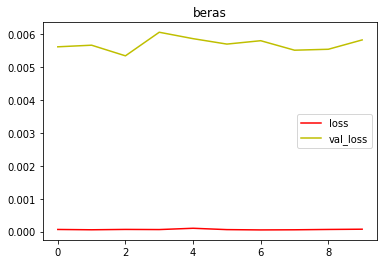

In [ ]:
plot_value(history_beras, 'beras')

## Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mean_absolute_percentage_error(data_test, results), mean_absolute_error(data_test, results)

prediction = forecast_predict(model, x_test_beras, time_size=5, batch_size=1, shuffle_data=100)
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
data_test = x_test_beras[:-4]
data_test = data_test.reshape(-1)
daging_ay = scaller.fit_transform(x_test_beras.reshape(-1, 1))
t = time_step_generator(x_val_bawang_putih, time_size=5, batch_size=1, shuffle_data=100)
data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = result
mae = mean_absolute_error(data_test, result)
mape = mean_absolute_percentage_error(data_test, result)
data_new, mae, mape

In [ ]:
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
results.shape

In [ ]:
data_test = x_test_beras[:-4]
data_test = data_test.reshape(-1)
# data_test

In [ ]:
daging_ay = scaller.fit_transform(x_test_beras.reshape(-1, 1))
t = time_step_generator(x_val_bawang_putih, time_size=5, batch_size=1, shuffle_data=100)
model.evaluate(t)

In [ ]:
data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = result
data_new

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mean_absolute_percentage_error(data_test, results), mean_absolute_error(data_test, results)

In [ ]:
mae = mean_absolute_error(data_test, result)
mape = mean_absolute_percentage_error(data_test, result)
mae, mape

In [ ]:
# !pip install --upgrade xlrd

In [ ]:
tested = pd.read_excel('tested.xlsx', skiprows=8)
tested = tested.drop('No.', axis=1)
tested = tested.T.reset_index()
tested.columns = tested.loc[0]
tested = tested.drop(0)
tested = tested.rename(columns={'Komoditas(Rp)': 'Date'})
tested

In [ ]:
test_beras = tested['Daging Ayam'].values
minmaxtest = scaller.fit_transform(test_beras.reshape(-1, 1))
prediction_1 = forecast_predict(model, minmaxtest, time_size=2, batch_size=1, shuffle_data=1000)
result_1 = prediction_1.squeeze()
result_1.shape

In [ ]:
result_1, minmaxtest

In [ ]:
results_1 = result_1.reshape(-1, 1)
results_1 = scaller.inverse_transform(results_1).round(1)
results_1 = results_1.reshape(-1)
results_1.shape

In [ ]:
test_berass = test_beras[:-1]
date = tested['Date']
date = date[:-1]
new = pd.DataFrame()
new['date'] = date
new['actual'] = test_berass
new['prediction'] = results_1.round()
new

In [ ]:
minn = minmaxtest.reshape(-1)
minn = minn[:-1]

testt = test_beras[:-1]
mae = mean_absolute_error(minn, result_1)
mape = mean_absolute_percentage_error(testt, results_1)
mae, mape

In [ ]:
tessss = testt.reshape(-1, 1, 1)
res = results.reshape(-1, 1, 1)
tessss.shape

In [ ]:
mae = mean_absolute_error(minn, result_1)
# mape = mean_absolute_percentage_error(tessss, res)
mae, mape

## Implementation

In [ ]:
predict_list = []

batch = x_train_beras[-30:].reshape((1, 30, 1))
for i in range(100):
  predict_list.append(model.predict(batch)[0])
  batch = np.append(batch[:, 1:, :], [[predict_list[i]]], axis=1)

add_dates = []

predicted = pd.DataFrame(scaller.inverse_transform(predict_list), 
                         columns=['prediction'])

# predicted['date'] = y_train_bawang_putih[-30:]
# predicted['actual'] = x_train_bawang_putih[-30:]

In [ ]:
predicted

In [ ]:
mean_absolute_percentage_error(x_train_beras[-30:], scaller.inverse_transform(predict_list))

# predicted